<a href="https://colab.research.google.com/github/lililibin2022/Learning-Notes/blob/main/train%20SuperGradients_%2B_YOLONAS_CCHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




Let's get to it...

🚨 Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime.

This is a known [issue](https://github.com/obss/sahi/discussions/781) that is on our roadmap.

In [2]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

# 🦸🏾‍♂️ SuperGradients

SuperGradients is a PyTorch based training library.

It provides a uniform interface for the most common computer vision use cases:

- Classification

- Detection

- Segmentation

- Pose estimation

There are nearly 40 pretrained models in our model zoo. You can see the pretrained models available to you by following [this link](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/model_zoo.md).

This notebook will focus on using SuperGradients with YOLO-NAS. If you're interested in seeing how SG is used for image classification, you can check out [this templated notebook](https://colab.research.google.com/drive/1JYyEnEh2VdmKLxd7idUfBt6vLGOZxGIp?usp=sharing) that will make it easy to get started.

# 🫣 Sneak peek: Inference with YOLONAS

Before jumping into the section on fine-tuning, I wanted to show you the power of YOLONAS out of the box.

Start by instantiating a pretrained model. YOLONAS comes in three flavors: `yolo_nas_s`, `yolo_nas_m`, and `yolo_nas_l`.

You'll use `yolo_nas_l` throughout this notebook. Because you should always go big, or go home.

It's a good life philosophy.

In [3]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

[2023-09-05 10:49:29] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-09-05 10:49:32] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-05 10:49:37] INFO - utils.py - NumExpr defaulting to 8 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-05 10:49:38] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-05 10:49:38] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-05 10:49:38] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-09-05 10:49:38] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-09-05 10:49:38] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-09-05 10:49:38] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-09-05 10:49:38] WARNING

You can run the following cell if you're interested in the architecture:

In [4]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

## 🖼️ Inference on an image

Once the model has been instantiated all you have to do is call the `predict` method.

This method operates on:
* PIL Image
* Numpy Image
* A path to image file
* A path to video file
* A path to folder with images
* URL (Image only)

Allowing you to perform inference with ease.

Note predict also has an argument called `conf`, which is the threshold for a detection. You change this value as you like, for example `model.predict("path/to/asset",conf=0.25)`

Let's perform inference on the following image:

<img src='https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg'>


[2023-09-05 09:06:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


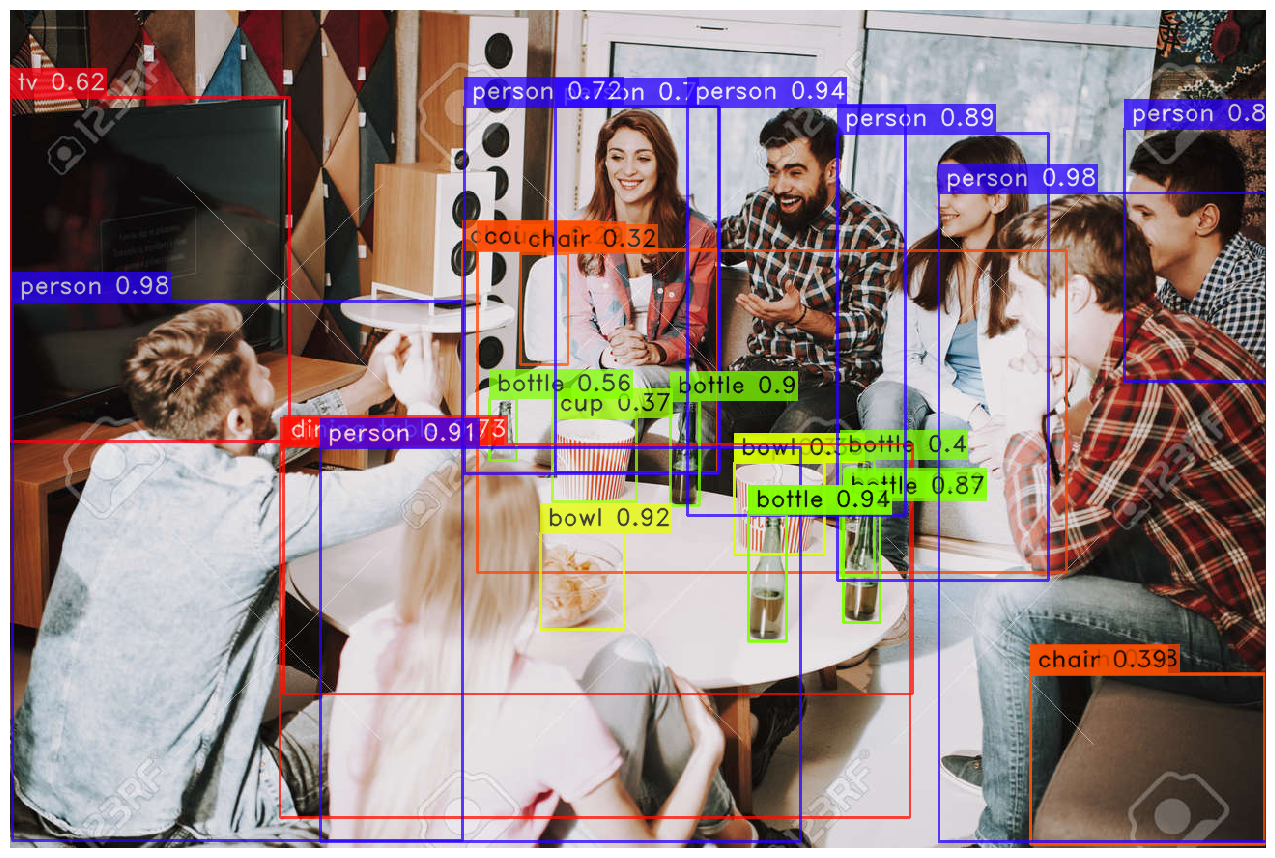

In [ ]:
url = "https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg"
yolo_nas_l.predict(url, conf=0.25).show()

### 🤷🏽‍♂️ What's happening "under the hood"

1. Input image gets through the preprocessing pipeline, which includes image resizing, normalization and permute operation to convert input RGB image to torch tensor.
2. Model inference
3. Postprocessing of the detection results (Non-maximum suppression, resizing bounding boxes to the size of original image)
4. Visualization of the results (Rendering of bounding boxes on top of the image)

# 🎥 Inference on video

The following code will display and download stock footage video from YouTube.

[Here's a link](https://www.youtube.com/watch?v=4poqZjNTZjI&list=PLcKa-34z76PvI5KvI5S2JGj0RcBVuz3jg) to a playlist that has a lot of stock video clips which are 2mins in length or less.

### 🔎🤩 Find a video you like and use YOLONAS to perform some inference on it!

All you have to do is get the `video_id`, and replace the line `video_id = 'aE8I7bDf62M' ` in the cell below with your chosen video's id.

The `video_id` is everything that comes after `https://www.youtube.com/watch?v=`. For the video below, the full url was `https://www.youtube.com/watch?v=aE8I7bDf62M`, and thus the video id is `aE8I7bDf62M`.

After you've found a video and performed inference, don't forget to share it on Twitter or LinkedIn.

🏷️ And tag me in it so I don't miss it!

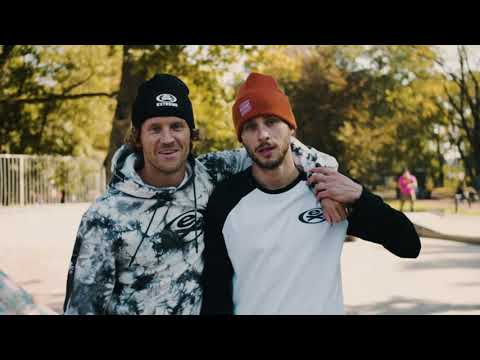

In [ ]:
# Import the YouTubeVideo class from IPython.display
from IPython.display import YouTubeVideo

# Define the YouTube video ID
video_id = 'aE8I7bDf62M'  # Replace YOUR_VIDEO_ID with the actual video ID

# Create a YouTubeVideo object with the specified video ID
video = YouTubeVideo(video_id)

# Display the video
display(video)

In [ ]:
%%capture

# Define the URL of the YouTube video
video_url = f'https://www.youtube.com/watch?v={video_id}'

# Download the video in mp4 format
!pip install -U "git+https://github.com/ytdl-org/youtube-dl.git"
!python -m youtube_dl -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4' "$video_url"

# Print a success message
print('Video downloaded successfully')

input_video_path = f"/content/EXTREME SPORTS X DIVERSE-{video_id}.mp4"
output_video_path = "detections.mp4"

### 📽️ Now, you'll peform inference on the video

Note, Google Colab is notorious for making it hard to display videos.

👀 Look to the left of the screen for the folder icon, it looks something like this: 🖿.

Click on that, and you'll see a file called `detections.mp4`.

Double click on that to download.

Google Colab is also notorious for taking a long time to download. You can continue on with the rest of the notebook while you wait.

If you have a work around for this, let me know!

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
yolo_nas_l.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 1137/1137 [00:27<00:00, 41.30it/s]


### 💻 Inference via webcam

Check [the documentation](https://github.com/Deci-AI/super-gradients/blob/505f646728249b9b35ea9060f34936f4e88234fd/src/super_gradients/examples/predict/detection_predict_streaming.py) for inference via webcam.

In [ ]:
import torch
from super_gradients.common.object_names import Models
from super_gradients.training import models

In [ ]:
# Note that currently only YoloX and PPYoloE are supported.
model = models.get(Models.YOLOX_N, pretrained_weights="coco")


[2023-09-05 09:11:56] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_n


In [ ]:

# We want to use cuda if available to speed up inference.
model = model.to("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
model.predict_webcam(0)

ValueError: ignored

In [ ]:
import cv2

# Try to access the default webcam (usually index 0)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Webcam not available or could not be opened.")
else:
    # Retrieve webcam properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    print("Webcam is available and opened successfully.")
    print(f"Frame Width: {width}")
    print(f"Frame Height: {height}")
    print(f"Frames Per Second (FPS): {fps}")

    # Release the webcam
    cap.release()


Webcam not available or could not be opened.


# 🪡 Fine-tuning YOLONAS on custom dataset

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

1) `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

2)`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

SuperGradients supports **Data Parallel** and **Distributed Data Parallel**.

That's outside of the scope for this introduction to SuperGradients. But, if you're fortunate enough to have multiple GPUs at your disposal or want learn more you can do so [here](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/device.md#3-dp---data-parallel).

In the code below, you'll instantiate the trainer with just a single GPU (since that's what Google Colab provides)

In [5]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

# 💾 Datasets and DataLoaders

Before you start, you need to create a Roboflow [account and get your API key](https://app.roboflow.com/login). If you're not sure how to find your API key, [here's how](https://www.loom.com/share/05277274e8d542efaf9bc3f33c1396d3?sid=3a41d4c5-c0c7-4712-bf4b-6a8c7ba51947).

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is.

There are several well-known datasets for object detection, for example:

- COCO
- Pascal
- YOLODarkNet
- YOLOv5

SuperGradients provides ready-to-use dataloaders for these datasets. If you're interested in learning more about working with `COCOFormatDetectionDataset` and the more general `DetectionDataset` [check out the SuperGradients documentation on this topic](https://docs.deci.ai/super-gradients/docstring/training/datasets/#training.datasets.detection_datasets.coco_detection.COCODetectionDataset)

You can learn more about working with SuperGradients datasets, dataloaders, and configuration files [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Data.md)

SuperGradients supports a number of dataset formats, you can learn more about that [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ObjectDetection.md)

For this example you'll use the the [U.S. Coins Dataset](https://universe.roboflow.com/atathamuscoinsdataset/u.s.-coins-dataset-a.tatham/dataset/5) from [RoboFlow](https://app.roboflow.com/login) with the dataset in YOLOv5 format.

## Some datasets you might want to try:
 - [HuggingFace competition: Ship detection](https://huggingface.co/spaces/competitions/ship-detection)

- [Aquarium dataset on RoboFlow](https://public.roboflow.com/object-detection/aquarium)

- [Vehicles-OpenImages Dataset on RoboFlow](https://public.roboflow.com/object-detection/vehicles-openimages)

- [Winegrape detection](https://github.com/thsant/wgisd)

- [Low light object detection](https://github.com/cs-chan/Exclusively-Dark-Image-Dataset)

- [Infrafred person detection](https://camel.ece.gatech.edu/)

- [Pothole detection](https://www.kaggle.com/datasets/chitholian/annotated-potholes-dataset)

- [100k Labeled Road Images | Day, Night](https://www.kaggle.com/datasets/solesensei/solesensei_bdd100k)

- [Deep Fashion dataset](https://github.com/switchablenorms/DeepFashion2)

- [Playing card detection](https://www.kaggle.com/datasets/luantm/playing-card)

- [Anaomoly detection in videos](https://www.crcv.ucf.edu/projects/real-world/)

- [Underwater fish recognition](https://www.kaggle.com/datasets/aalborguniversity/brackish-dataset)

- [Document layout detection](https://www.primaresearch.org/datasets/Layout_Analysis)

- [Trash Annotations in Context](http://tacodataset.org/)

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KambJHvvNRVwsQ1xhopi")
project = rf.workspace("fafu").project("ccha_detector")
dataset = project.version(5).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to CCHA_detector-5 in yolov5pytorch:: 100%|██████████| 1242/1242 [00:00<00:00, 7740.02it/s]


Start by importing the required modules, which will help you create SuperGradients dataloaders.


In [7]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [8]:
dataset_params = {
    'data_dir':'/content/CCHA_detector-5',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['CC', 'HA']
}

You pass the values for `dataset_params` into the `dataset_params` argument as shown below.

You can also pass PyTorch DataLoaders arguments when instantiating your dataset. Here you'll set `batch_size=16` and `num_workers=2`.

Repeat this for the validation and testing datasets, note that for training and testing data we use `coco_detection_yolo_format_val` to instantiate the dataloader.

The dataloaders will print warnings when an annotation does not conform to the expected format. This particular dataset has many such annotations, thus the warnings will be muted.

In [9]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 61/61 [00:00<00:00, 4557.97it/s]


### 🧐 Now inspect the dataset defined earlier.

SuperGradients added `transforms` for you. You're free to experiment with these transformations as you please. You can also add in your own transformations from `torchvision.transforms` or a custom tranformaton.

In [10]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

You can plot a batch of training data with their augmentations applied to see what they look like:

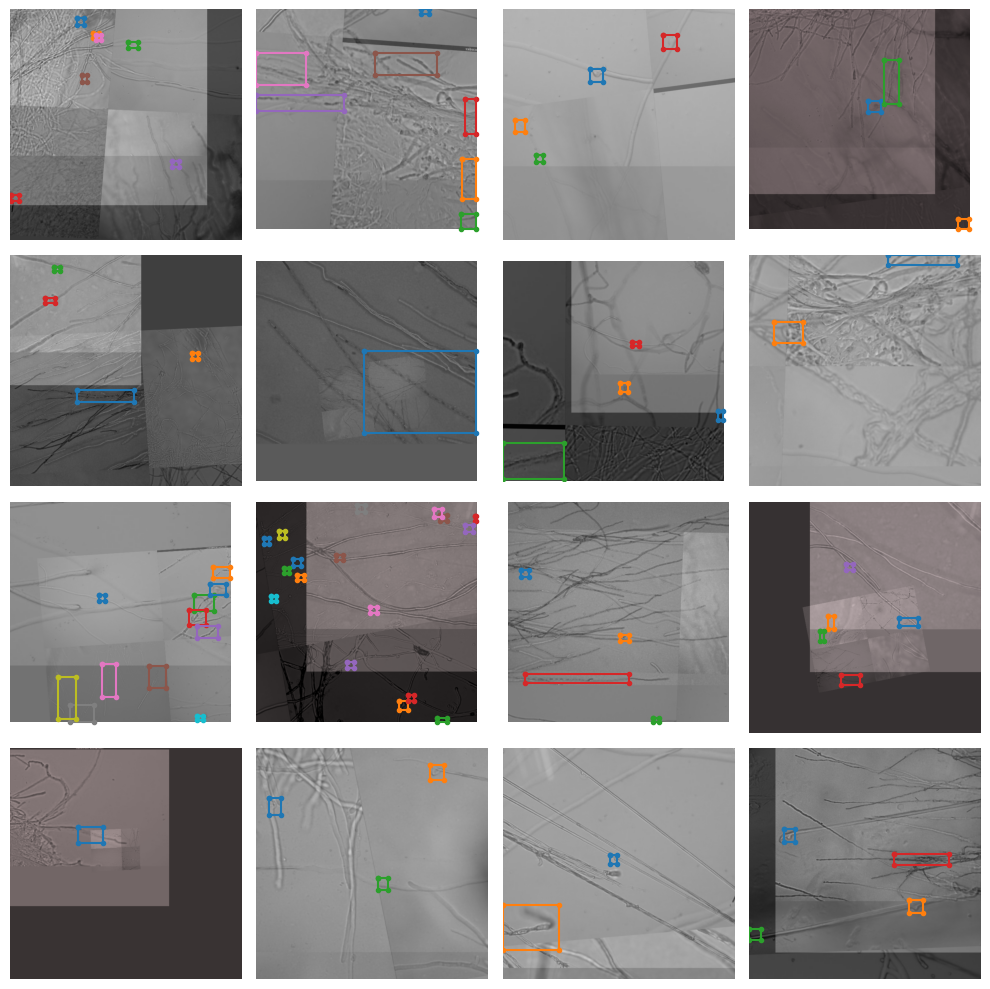

In [34]:
train_data.dataset.plot()

# 👩🏽‍🦳 Instantiating the model

You saw how to instantiate the model for inference earlier.

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [12]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-09-05 10:52:01] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-09-05 10:52:01] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


### 🧑🏾‍🔬 Integrations with experiment monitoring tools

SuperGradients has native integrations with Tensorboard, Weights and Biases, ClearML, and DagsHub.

If your favorite monitoring tool is not supported by SuperGradients, you can simply implement a class inheriting from BaseSGLogger that you will then pass to the training parameters.

If you're interested in monitoring experiments, you can learn more [in the docs](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/experiment_monitoring.md).


### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [21]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Training the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [22]:
trainer.train(model=best_model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/my_first_yolonas_run/console_Sep05_11_42_06.txt


[2023-09-05 11:42:06] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-05 11:42:09] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 427        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         26         (len(train_loader))
    - Gradient updates per epoch:   26         (len(train_loader) / batch_accumulate)

[2023-09-05 11:42:09] INFO - sg_trainer.py - Started training for 100 epochs (0/99)

Validating: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]
[2023-09-05 11:42:47] INFO - base_sg_logger.py -

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2072
│   ├── Ppyoloeloss/loss_iou = 0.3242
│   ├── Ppyoloeloss/loss_dfl = 1.1909
│   └── Ppyoloeloss/loss = 2.6132
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1894
    ├── Ppyoloeloss/loss_iou = 0.2972
    ├── Ppyoloeloss/loss_dfl = 1.1429
    ├── Ppyoloeloss/loss = 2.5038
    ├── Precision@0.50 = 0.0275
    ├── Recall@0.50 = 0.8552
    ├── Map@0.50 = 0.2488
    └── F1@0.50 = 0.0528



Validating epoch 1: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2328
│   │   ├── Epoch N-1      = 1.2072 (↗ 0.0256)
│   │   └── Best until now = 1.2072 (↗ 0.0256)
│   ├── Ppyoloeloss/loss_iou = 0.342
│   │   ├── Epoch N-1      = 0.3242 (↗ 0.0177)
│   │   └── Best until now = 0.3242 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_dfl = 1.2393
│   │   ├── Epoch N-1      = 1.1909 (↗ 0.0484)
│   │   └── Best until now = 1.1909 (↗ 0.0484)
│   └── Ppyoloeloss/loss = 2.7074
│       ├── Epoch N-1      = 2.6132 (↗ 0.0942)
│       └── Best until now = 2.6132 (↗ 0.0942)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2824
    │   ├── Epoch N-1      = 1.1894 (↗ 0.0931)
    │   └── Best until now = 1.1894 (↗ 0.0931)
    ├── Ppyoloeloss/loss_iou = 0.3023
    │   ├── Epoch N-1      = 0.2972 (↗ 0.0051)
    │   └── Best until now = 0.2972 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 1.1708
    │   ├── Epoch N-1      = 1.1429 (↗ 0.0279)
    │   └── Best until now = 1.1429 (↗ 0.0279)
    ├── Ppyoloeloss/loss = 2.6235
   

Validating epoch 2: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2255
│   │   ├── Epoch N-1      = 1.2328 (↘ -0.0073)
│   │   └── Best until now = 1.2072 (↗ 0.0184)
│   ├── Ppyoloeloss/loss_iou = 0.3496
│   │   ├── Epoch N-1      = 0.342  (↗ 0.0077)
│   │   └── Best until now = 0.3242 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_dfl = 1.2894
│   │   ├── Epoch N-1      = 1.2393 (↗ 0.0501)
│   │   └── Best until now = 1.1909 (↗ 0.0985)
│   └── Ppyoloeloss/loss = 2.7444
│       ├── Epoch N-1      = 2.7074 (↗ 0.037)
│       └── Best until now = 2.6132 (↗ 0.1311)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.268
    │   ├── Epoch N-1      = 1.2824 (↘ -0.0144)
    │   └── Best until now = 1.1894 (↗ 0.0787)
    ├── Ppyoloeloss/loss_iou = 0.3382
    │   ├── Epoch N-1      = 0.3023 (↗ 0.036)
    │   └── Best until now = 0.2972 (↗ 0.041)
    ├── Ppyoloeloss/loss_dfl = 1.2165
    │   ├── Epoch N-1      = 1.1708 (↗ 0.0457)
    │   └── Best until now = 1.1429 (↗ 0.0736)
    ├── Ppyoloeloss/loss = 2.7218
    

Validating epoch 3: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2677
│   │   ├── Epoch N-1      = 1.2255 (↗ 0.0422)
│   │   └── Best until now = 1.2072 (↗ 0.0605)
│   ├── Ppyoloeloss/loss_iou = 0.3682
│   │   ├── Epoch N-1      = 0.3496 (↗ 0.0185)
│   │   └── Best until now = 0.3242 (↗ 0.0439)
│   ├── Ppyoloeloss/loss_dfl = 1.324
│   │   ├── Epoch N-1      = 1.2894 (↗ 0.0346)
│   │   └── Best until now = 1.1909 (↗ 0.1331)
│   └── Ppyoloeloss/loss = 2.8502
│       ├── Epoch N-1      = 2.7444 (↗ 0.1058)
│       └── Best until now = 2.6132 (↗ 0.237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5081
    │   ├── Epoch N-1      = 1.268  (↗ 0.2401)
    │   └── Best until now = 1.1894 (↗ 0.3187)
    ├── Ppyoloeloss/loss_iou = 0.408
    │   ├── Epoch N-1      = 0.3382 (↗ 0.0698)
    │   └── Best until now = 0.2972 (↗ 0.1109)
    ├── Ppyoloeloss/loss_dfl = 1.1508
    │   ├── Epoch N-1      = 1.2165 (↘ -0.0657)
    │   └── Best until now = 1.1429 (↗ 0.0079)
    ├── Ppyoloeloss/loss = 3.1036
    

Validating epoch 4: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2732
│   │   ├── Epoch N-1      = 1.2677 (↗ 0.0055)
│   │   └── Best until now = 1.2072 (↗ 0.066)
│   ├── Ppyoloeloss/loss_iou = 0.3724
│   │   ├── Epoch N-1      = 0.3682 (↗ 0.0042)
│   │   └── Best until now = 0.3242 (↗ 0.0481)
│   ├── Ppyoloeloss/loss_dfl = 1.3548
│   │   ├── Epoch N-1      = 1.324  (↗ 0.0308)
│   │   └── Best until now = 1.1909 (↗ 0.1639)
│   └── Ppyoloeloss/loss = 2.8815
│       ├── Epoch N-1      = 2.8502 (↗ 0.0313)
│       └── Best until now = 2.6132 (↗ 0.2683)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3649
    │   ├── Epoch N-1      = 1.5081 (↘ -0.1432)
    │   └── Best until now = 1.1894 (↗ 0.1755)
    ├── Ppyoloeloss/loss_iou = 0.4059
    │   ├── Epoch N-1      = 0.408  (↘ -0.0021)
    │   └── Best until now = 0.2972 (↗ 0.1087)
    ├── Ppyoloeloss/loss_dfl = 1.5103
    │   ├── Epoch N-1      = 1.1508 (↗ 0.3594)
    │   └── Best until now = 1.1429 (↗ 0.3674)
    ├── Ppyoloeloss/loss = 3.1349
 

Validating epoch 5: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2632
│   │   ├── Epoch N-1      = 1.2732 (↘ -0.01)
│   │   └── Best until now = 1.2072 (↗ 0.056)
│   ├── Ppyoloeloss/loss_iou = 0.3701
│   │   ├── Epoch N-1      = 0.3724 (↘ -0.0022)
│   │   └── Best until now = 0.3242 (↗ 0.0459)
│   ├── Ppyoloeloss/loss_dfl = 1.3524
│   │   ├── Epoch N-1      = 1.3548 (↘ -0.0024)
│   │   └── Best until now = 1.1909 (↗ 0.1614)
│   └── Ppyoloeloss/loss = 2.8647
│       ├── Epoch N-1      = 2.8815 (↘ -0.0168)
│       └── Best until now = 2.6132 (↗ 0.2515)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5392
    │   ├── Epoch N-1      = 1.3649 (↗ 0.1743)
    │   └── Best until now = 1.1894 (↗ 0.3498)
    ├── Ppyoloeloss/loss_iou = 0.3243
    │   ├── Epoch N-1      = 0.4059 (↘ -0.0816)
    │   └── Best until now = 0.2972 (↗ 0.0271)
    ├── Ppyoloeloss/loss_dfl = 1.2717
    │   ├── Epoch N-1      = 1.5103 (↘ -0.2386)
    │   └── Best until now = 1.1429 (↗ 0.1288)
    ├── Ppyoloeloss/loss = 2.9859

Validating epoch 6: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2402
│   │   ├── Epoch N-1      = 1.2632 (↘ -0.023)
│   │   └── Best until now = 1.2072 (↗ 0.0331)
│   ├── Ppyoloeloss/loss_iou = 0.3598
│   │   ├── Epoch N-1      = 0.3701 (↘ -0.0104)
│   │   └── Best until now = 0.3242 (↗ 0.0355)
│   ├── Ppyoloeloss/loss_dfl = 1.2962
│   │   ├── Epoch N-1      = 1.3524 (↘ -0.0561)
│   │   └── Best until now = 1.1909 (↗ 0.1053)
│   └── Ppyoloeloss/loss = 2.7877
│       ├── Epoch N-1      = 2.8647 (↘ -0.0769)
│       └── Best until now = 2.6132 (↗ 0.1745)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2121
    │   ├── Epoch N-1      = 1.5392 (↘ -0.3271)
    │   └── Best until now = 1.1894 (↗ 0.0227)
    ├── Ppyoloeloss/loss_iou = 0.3263
    │   ├── Epoch N-1      = 0.3243 (↗ 0.002)
    │   └── Best until now = 0.2972 (↗ 0.0291)
    ├── Ppyoloeloss/loss_dfl = 1.2357
    │   ├── Epoch N-1      = 1.2717 (↘ -0.036)
    │   └── Best until now = 1.1429 (↗ 0.0928)
    ├── Ppyoloeloss/loss = 2.6458

Validating epoch 7: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2522
│   │   ├── Epoch N-1      = 1.2402 (↗ 0.012)
│   │   └── Best until now = 1.2072 (↗ 0.0451)
│   ├── Ppyoloeloss/loss_iou = 0.3549
│   │   ├── Epoch N-1      = 0.3598 (↘ -0.0049)
│   │   └── Best until now = 0.3242 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_dfl = 1.293
│   │   ├── Epoch N-1      = 1.2962 (↘ -0.0032)
│   │   └── Best until now = 1.1909 (↗ 0.1021)
│   └── Ppyoloeloss/loss = 2.7859
│       ├── Epoch N-1      = 2.7877 (↘ -0.0018)
│       └── Best until now = 2.6132 (↗ 0.1727)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3883
    │   ├── Epoch N-1      = 1.2121 (↗ 0.1762)
    │   └── Best until now = 1.1894 (↗ 0.199)
    ├── Ppyoloeloss/loss_iou = 0.3167
    │   ├── Epoch N-1      = 0.3263 (↘ -0.0097)
    │   └── Best until now = 0.2972 (↗ 0.0195)
    ├── Ppyoloeloss/loss_dfl = 1.2336
    │   ├── Epoch N-1      = 1.2357 (↘ -0.0021)
    │   └── Best until now = 1.1429 (↗ 0.0907)
    ├── Ppyoloeloss/loss = 2.7969


Validating epoch 8: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2436
│   │   ├── Epoch N-1      = 1.2522 (↘ -0.0086)
│   │   └── Best until now = 1.2072 (↗ 0.0365)
│   ├── Ppyoloeloss/loss_iou = 0.3483
│   │   ├── Epoch N-1      = 0.3549 (↘ -0.0066)
│   │   └── Best until now = 0.3242 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 1.2813
│   │   ├── Epoch N-1      = 1.293  (↘ -0.0117)
│   │   └── Best until now = 1.1909 (↗ 0.0904)
│   └── Ppyoloeloss/loss = 2.755
│       ├── Epoch N-1      = 2.7859 (↘ -0.031)
│       └── Best until now = 2.6132 (↗ 0.1418)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2483
    │   ├── Epoch N-1      = 1.3883 (↘ -0.1401)
    │   └── Best until now = 1.1894 (↗ 0.0589)
    ├── Ppyoloeloss/loss_iou = 0.322
    │   ├── Epoch N-1      = 0.3167 (↗ 0.0053)
    │   └── Best until now = 0.2972 (↗ 0.0248)
    ├── Ppyoloeloss/loss_dfl = 1.2345
    │   ├── Epoch N-1      = 1.2336 (↗ 0.0009)
    │   └── Best until now = 1.1429 (↗ 0.0916)
    ├── Ppyoloeloss/loss = 2.6705
 

Validating epoch 9: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2325
│   │   ├── Epoch N-1      = 1.2436 (↘ -0.0111)
│   │   └── Best until now = 1.2072 (↗ 0.0254)
│   ├── Ppyoloeloss/loss_iou = 0.3512
│   │   ├── Epoch N-1      = 0.3483 (↗ 0.0029)
│   │   └── Best until now = 0.3242 (↗ 0.0269)
│   ├── Ppyoloeloss/loss_dfl = 1.2711
│   │   ├── Epoch N-1      = 1.2813 (↘ -0.0102)
│   │   └── Best until now = 1.1909 (↗ 0.0802)
│   └── Ppyoloeloss/loss = 2.746
│       ├── Epoch N-1      = 2.755  (↘ -0.009)
│       └── Best until now = 2.6132 (↗ 0.1328)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2518
    │   ├── Epoch N-1      = 1.2483 (↗ 0.0036)
    │   └── Best until now = 1.1894 (↗ 0.0625)
    ├── Ppyoloeloss/loss_iou = 0.3198
    │   ├── Epoch N-1      = 0.322  (↘ -0.0022)
    │   └── Best until now = 0.2972 (↗ 0.0226)
    ├── Ppyoloeloss/loss_dfl = 1.214
    │   ├── Epoch N-1      = 1.2345 (↘ -0.0205)
    │   └── Best until now = 1.1429 (↗ 0.0711)
    ├── Ppyoloeloss/loss = 2.6582


Validating epoch 10: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2397
│   │   ├── Epoch N-1      = 1.2325 (↗ 0.0071)
│   │   └── Best until now = 1.2072 (↗ 0.0325)
│   ├── Ppyoloeloss/loss_iou = 0.3482
│   │   ├── Epoch N-1      = 0.3512 (↘ -0.0029)
│   │   └── Best until now = 0.3242 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 1.277
│   │   ├── Epoch N-1      = 1.2711 (↗ 0.0059)
│   │   └── Best until now = 1.1909 (↗ 0.0861)
│   └── Ppyoloeloss/loss = 2.7487
│       ├── Epoch N-1      = 2.746  (↗ 0.0027)
│       └── Best until now = 2.6132 (↗ 0.1355)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.278
    │   ├── Epoch N-1      = 1.2518 (↗ 0.0261)
    │   └── Best until now = 1.1894 (↗ 0.0886)
    ├── Ppyoloeloss/loss_iou = 0.31
    │   ├── Epoch N-1      = 0.3198 (↘ -0.0098)
    │   └── Best until now = 0.2972 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 1.204
    │   ├── Epoch N-1      = 1.214  (↘ -0.01)
    │   └── Best until now = 1.1429 (↗ 0.0611)
    ├── Ppyoloeloss/loss = 2.6549
    │ 

Validating epoch 11: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2223
│   │   ├── Epoch N-1      = 1.2397 (↘ -0.0174)
│   │   └── Best until now = 1.2072 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_iou = 0.3441
│   │   ├── Epoch N-1      = 0.3482 (↘ -0.0041)
│   │   └── Best until now = 0.3242 (↗ 0.0199)
│   ├── Ppyoloeloss/loss_dfl = 1.2601
│   │   ├── Epoch N-1      = 1.277  (↘ -0.0169)
│   │   └── Best until now = 1.1909 (↗ 0.0692)
│   └── Ppyoloeloss/loss = 2.7125
│       ├── Epoch N-1      = 2.7487 (↘ -0.0362)
│       └── Best until now = 2.6132 (↗ 0.0993)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2685
    │   ├── Epoch N-1      = 1.278  (↘ -0.0094)
    │   └── Best until now = 1.1894 (↗ 0.0792)
    ├── Ppyoloeloss/loss_iou = 0.3155
    │   ├── Epoch N-1      = 0.31   (↗ 0.0055)
    │   └── Best until now = 0.2972 (↗ 0.0183)
    ├── Ppyoloeloss/loss_dfl = 1.2147
    │   ├── Epoch N-1      = 1.204  (↗ 0.0107)
    │   └── Best until now = 1.1429 (↗ 0.0718)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 12: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]
[2023-09-05 11:52:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 11:52:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.257236123085022


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2144
│   │   ├── Epoch N-1      = 1.2223 (↘ -0.0078)
│   │   └── Best until now = 1.2072 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.3411
│   │   ├── Epoch N-1      = 0.3441 (↘ -0.003)
│   │   └── Best until now = 0.3242 (↗ 0.0168)
│   ├── Ppyoloeloss/loss_dfl = 1.2613
│   │   ├── Epoch N-1      = 1.2601 (↗ 0.0012)
│   │   └── Best until now = 1.1909 (↗ 0.0704)
│   └── Ppyoloeloss/loss = 2.6977
│       ├── Epoch N-1      = 2.7125 (↘ -0.0148)
│       └── Best until now = 2.6132 (↗ 0.0845)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2715
    │   ├── Epoch N-1      = 1.2685 (↗ 0.003)
    │   └── Best until now = 1.1894 (↗ 0.0822)
    ├── Ppyoloeloss/loss_iou = 0.2994
    │   ├── Epoch N-1      = 0.3155 (↘ -0.0161)
    │   └── Best until now = 0.2972 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 1.1459
    │   ├── Epoch N-1      = 1.2147 (↘ -0.0688)
    │   └── Best until now = 1.1429 (↗ 0.003)
    ├── Ppyoloeloss/loss = 2.593


Validating epoch 13: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
[2023-09-05 11:53:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 11:53:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.27796998620033264


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2006
│   │   ├── Epoch N-1      = 1.2144 (↘ -0.0138)
│   │   └── Best until now = 1.2072 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.3381
│   │   ├── Epoch N-1      = 0.3411 (↘ -0.003)
│   │   └── Best until now = 0.3242 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_dfl = 1.2613
│   │   ├── Epoch N-1      = 1.2613 (↗ 0.0)
│   │   └── Best until now = 1.1909 (↗ 0.0704)
│   └── Ppyoloeloss/loss = 2.6764
│       ├── Epoch N-1      = 2.6977 (↘ -0.0213)
│       └── Best until now = 2.6132 (↗ 0.0632)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1928
    │   ├── Epoch N-1      = 1.2715 (↘ -0.0787)
    │   └── Best until now = 1.1894 (↗ 0.0035)
    ├── Ppyoloeloss/loss_iou = 0.3079
    │   ├── Epoch N-1      = 0.2994 (↗ 0.0085)
    │   └── Best until now = 0.2972 (↗ 0.0107)
    ├── Ppyoloeloss/loss_dfl = 1.1602
    │   ├── Epoch N-1      = 1.1459 (↗ 0.0143)
    │   └── Best until now = 1.1429 (↗ 0.0173)
    ├── Ppyoloeloss/loss = 2.5426


Validating epoch 14: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.212
│   │   ├── Epoch N-1      = 1.2006 (↗ 0.0114)
│   │   └── Best until now = 1.2006 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.3303
│   │   ├── Epoch N-1      = 0.3381 (↘ -0.0078)
│   │   └── Best until now = 0.3242 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 1.2489
│   │   ├── Epoch N-1      = 1.2613 (↘ -0.0125)
│   │   └── Best until now = 1.1909 (↗ 0.058)
│   └── Ppyoloeloss/loss = 2.6622
│       ├── Epoch N-1      = 2.6764 (↘ -0.0142)
│       └── Best until now = 2.6132 (↗ 0.049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3488
    │   ├── Epoch N-1      = 1.1928 (↗ 0.1559)
    │   └── Best until now = 1.1894 (↗ 0.1594)
    ├── Ppyoloeloss/loss_iou = 0.3049
    │   ├── Epoch N-1      = 0.3079 (↘ -0.003)
    │   └── Best until now = 0.2972 (↗ 0.0077)
    ├── Ppyoloeloss/loss_dfl = 1.2
    │   ├── Epoch N-1      = 1.1602 (↗ 0.0397)
    │   └── Best until now = 1.1429 (↗ 0.0571)
    ├── Ppyoloeloss/loss = 2.7109
    

Validating epoch 15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2034
│   │   ├── Epoch N-1      = 1.212  (↘ -0.0086)
│   │   └── Best until now = 1.2006 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.3277
│   │   ├── Epoch N-1      = 0.3303 (↘ -0.0026)
│   │   └── Best until now = 0.3242 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 1.2554
│   │   ├── Epoch N-1      = 1.2489 (↗ 0.0065)
│   │   └── Best until now = 1.1909 (↗ 0.0645)
│   └── Ppyoloeloss/loss = 2.6503
│       ├── Epoch N-1      = 2.6622 (↘ -0.0119)
│       └── Best until now = 2.6132 (↗ 0.0371)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2238
    │   ├── Epoch N-1      = 1.3488 (↘ -0.125)
    │   └── Best until now = 1.1894 (↗ 0.0344)
    ├── Ppyoloeloss/loss_iou = 0.3037
    │   ├── Epoch N-1      = 0.3049 (↘ -0.0012)
    │   └── Best until now = 0.2972 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 1.1997
    │   ├── Epoch N-1      = 1.2    (↘ -0.0003)
    │   └── Best until now = 1.1429 (↗ 0.0568)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 16: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2098
│   │   ├── Epoch N-1      = 1.2034 (↗ 0.0064)
│   │   └── Best until now = 1.2006 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.3343
│   │   ├── Epoch N-1      = 0.3277 (↗ 0.0067)
│   │   └── Best until now = 0.3242 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 1.236
│   │   ├── Epoch N-1      = 1.2554 (↘ -0.0194)
│   │   └── Best until now = 1.1909 (↗ 0.0451)
│   └── Ppyoloeloss/loss = 2.6637
│       ├── Epoch N-1      = 2.6503 (↗ 0.0133)
│       └── Best until now = 2.6132 (↗ 0.0504)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2685
    │   ├── Epoch N-1      = 1.2238 (↗ 0.0447)
    │   └── Best until now = 1.1894 (↗ 0.0791)
    ├── Ppyoloeloss/loss_iou = 0.2958
    │   ├── Epoch N-1      = 0.3037 (↘ -0.0079)
    │   └── Best until now = 0.2972 (↘ -0.0014)
    ├── Ppyoloeloss/loss_dfl = 1.1739
    │   ├── Epoch N-1      = 1.1997 (↘ -0.0258)
    │   └── Best until now = 1.1429 (↗ 0.031)
    ├── Ppyoloeloss/loss = 2.5949

Validating epoch 17: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1901
│   │   ├── Epoch N-1      = 1.2098 (↘ -0.0197)
│   │   └── Best until now = 1.2006 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.3304
│   │   ├── Epoch N-1      = 0.3343 (↘ -0.0039)
│   │   └── Best until now = 0.3242 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_dfl = 1.1749
│   │   ├── Epoch N-1      = 1.236  (↘ -0.0611)
│   │   └── Best until now = 1.1909 (↘ -0.016)
│   └── Ppyoloeloss/loss = 2.6036
│       ├── Epoch N-1      = 2.6637 (↘ -0.06)
│       └── Best until now = 2.6132 (↘ -0.0096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1574
    │   ├── Epoch N-1      = 1.2685 (↘ -0.1111)
    │   └── Best until now = 1.1894 (↘ -0.032)
    ├── Ppyoloeloss/loss_iou = 0.3002
    │   ├── Epoch N-1      = 0.2958 (↗ 0.0044)
    │   └── Best until now = 0.2958 (↗ 0.0044)
    ├── Ppyoloeloss/loss_dfl = 1.17
    │   ├── Epoch N-1      = 1.1739 (↘ -0.0039)
    │   └── Best until now = 1.1429 (↗ 0.0271)
    ├── Ppyoloeloss/loss = 2.49

Validating epoch 18: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1924
│   │   ├── Epoch N-1      = 1.1901 (↗ 0.0023)
│   │   └── Best until now = 1.1901 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.3333
│   │   ├── Epoch N-1      = 0.3304 (↗ 0.0029)
│   │   └── Best until now = 0.3242 (↗ 0.0091)
│   ├── Ppyoloeloss/loss_dfl = 1.2261
│   │   ├── Epoch N-1      = 1.1749 (↗ 0.0512)
│   │   └── Best until now = 1.1749 (↗ 0.0512)
│   └── Ppyoloeloss/loss = 2.6388
│       ├── Epoch N-1      = 2.6036 (↗ 0.0352)
│       └── Best until now = 2.6036 (↗ 0.0352)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2001
    │   ├── Epoch N-1      = 1.1574 (↗ 0.0427)
    │   └── Best until now = 1.1574 (↗ 0.0427)
    ├── Ppyoloeloss/loss_iou = 0.3048
    │   ├── Epoch N-1      = 0.3002 (↗ 0.0047)
    │   └── Best until now = 0.2958 (↗ 0.0091)
    ├── Ppyoloeloss/loss_dfl = 1.1788
    │   ├── Epoch N-1      = 1.17   (↗ 0.0088)
    │   └── Best until now = 1.1429 (↗ 0.0359)
    ├── Ppyoloeloss/loss = 2.5516
 

Validating epoch 19: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1876
│   │   ├── Epoch N-1      = 1.1924 (↘ -0.0048)
│   │   └── Best until now = 1.1901 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.3217
│   │   ├── Epoch N-1      = 0.3333 (↘ -0.0117)
│   │   └── Best until now = 0.3242 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 1.1798
│   │   ├── Epoch N-1      = 1.2261 (↘ -0.0463)
│   │   └── Best until now = 1.1749 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 2.5816
│       ├── Epoch N-1      = 2.6388 (↘ -0.0572)
│       └── Best until now = 2.6036 (↘ -0.022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2229
    │   ├── Epoch N-1      = 1.2001 (↗ 0.0228)
    │   └── Best until now = 1.1574 (↗ 0.0655)
    ├── Ppyoloeloss/loss_iou = 0.3023
    │   ├── Epoch N-1      = 0.3048 (↘ -0.0025)
    │   └── Best until now = 0.2958 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 1.1595
    │   ├── Epoch N-1      = 1.1788 (↘ -0.0193)
    │   └── Best until now = 1.1429 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 

Validating epoch 20: 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]
[2023-09-05 11:58:54] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 11:58:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.29082489013671875


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1944
│   │   ├── Epoch N-1      = 1.1876 (↗ 0.0068)
│   │   └── Best until now = 1.1876 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.3205
│   │   ├── Epoch N-1      = 0.3217 (↘ -0.0011)
│   │   └── Best until now = 0.3217 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 1.2065
│   │   ├── Epoch N-1      = 1.1798 (↗ 0.0267)
│   │   └── Best until now = 1.1749 (↗ 0.0316)
│   └── Ppyoloeloss/loss = 2.599
│       ├── Epoch N-1      = 2.5816 (↗ 0.0174)
│       └── Best until now = 2.5816 (↗ 0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2296
    │   ├── Epoch N-1      = 1.2229 (↗ 0.0066)
    │   └── Best until now = 1.1574 (↗ 0.0722)
    ├── Ppyoloeloss/loss_iou = 0.2985
    │   ├── Epoch N-1      = 0.3023 (↘ -0.0038)
    │   └── Best until now = 0.2958 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 1.1519
    │   ├── Epoch N-1      = 1.1595 (↘ -0.0076)
    │   └── Best until now = 1.1429 (↗ 0.009)
    ├── Ppyoloeloss/loss = 2.5518

Validating epoch 21: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2124
│   │   ├── Epoch N-1      = 1.1944 (↗ 0.018)
│   │   └── Best until now = 1.1876 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_iou = 0.3227
│   │   ├── Epoch N-1      = 0.3205 (↗ 0.0021)
│   │   └── Best until now = 0.3205 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 1.2245
│   │   ├── Epoch N-1      = 1.2065 (↗ 0.018)
│   │   └── Best until now = 1.1749 (↗ 0.0496)
│   └── Ppyoloeloss/loss = 2.6313
│       ├── Epoch N-1      = 2.599  (↗ 0.0323)
│       └── Best until now = 2.5816 (↗ 0.0497)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2246
    │   ├── Epoch N-1      = 1.2296 (↘ -0.0049)
    │   └── Best until now = 1.1574 (↗ 0.0673)
    ├── Ppyoloeloss/loss_iou = 0.3064
    │   ├── Epoch N-1      = 0.2985 (↗ 0.0079)
    │   └── Best until now = 0.2958 (↗ 0.0106)
    ├── Ppyoloeloss/loss_dfl = 1.2274
    │   ├── Epoch N-1      = 1.1519 (↗ 0.0754)
    │   └── Best until now = 1.1429 (↗ 0.0844)
    ├── Ppyoloeloss/loss = 2.6043
  

Validating epoch 22: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]
[2023-09-05 12:00:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:00:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.29718223214149475


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2091
│   │   ├── Epoch N-1      = 1.2124 (↘ -0.0034)
│   │   └── Best until now = 1.1876 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_iou = 0.3191
│   │   ├── Epoch N-1      = 0.3227 (↘ -0.0035)
│   │   └── Best until now = 0.3205 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 1.1867
│   │   ├── Epoch N-1      = 1.2245 (↘ -0.0378)
│   │   └── Best until now = 1.1749 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 2.6003
│       ├── Epoch N-1      = 2.6313 (↘ -0.031)
│       └── Best until now = 2.5816 (↗ 0.0187)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2017
    │   ├── Epoch N-1      = 1.2246 (↘ -0.0229)
    │   └── Best until now = 1.1574 (↗ 0.0444)
    ├── Ppyoloeloss/loss_iou = 0.3003
    │   ├── Epoch N-1      = 0.3064 (↘ -0.0061)
    │   └── Best until now = 0.2958 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 1.1667
    │   ├── Epoch N-1      = 1.2274 (↘ -0.0607)
    │   └── Best until now = 1.1429 (↗ 0.0238)
    ├── Ppyoloeloss/loss = 2

Validating epoch 23: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2068
│   │   ├── Epoch N-1      = 1.2091 (↘ -0.0023)
│   │   └── Best until now = 1.1876 (↗ 0.0192)
│   ├── Ppyoloeloss/loss_iou = 0.3175
│   │   ├── Epoch N-1      = 0.3191 (↘ -0.0017)
│   │   └── Best until now = 0.3191 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 1.2086
│   │   ├── Epoch N-1      = 1.1867 (↗ 0.0219)
│   │   └── Best until now = 1.1749 (↗ 0.0337)
│   └── Ppyoloeloss/loss = 2.6047
│       ├── Epoch N-1      = 2.6003 (↗ 0.0044)
│       └── Best until now = 2.5816 (↗ 0.0231)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2541
    │   ├── Epoch N-1      = 1.2017 (↗ 0.0524)
    │   └── Best until now = 1.1574 (↗ 0.0968)
    ├── Ppyoloeloss/loss_iou = 0.2942
    │   ├── Epoch N-1      = 0.3003 (↘ -0.0062)
    │   └── Best until now = 0.2958 (↘ -0.0016)
    ├── Ppyoloeloss/loss_dfl = 1.1397
    │   ├── Epoch N-1      = 1.1667 (↘ -0.027)
    │   └── Best until now = 1.1429 (↘ -0.0032)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 24: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2063
│   │   ├── Epoch N-1      = 1.2068 (↘ -0.0004)
│   │   └── Best until now = 1.1876 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.3174
│   │   ├── Epoch N-1      = 0.3175 (↘ -1e-04)
│   │   └── Best until now = 0.3175 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 1.2068
│   │   ├── Epoch N-1      = 1.2086 (↘ -0.0018)
│   │   └── Best until now = 1.1749 (↗ 0.0319)
│   └── Ppyoloeloss/loss = 2.6032
│       ├── Epoch N-1      = 2.6047 (↘ -0.0015)
│       └── Best until now = 2.5816 (↗ 0.0216)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1975
    │   ├── Epoch N-1      = 1.2541 (↘ -0.0566)
    │   └── Best until now = 1.1574 (↗ 0.0401)
    ├── Ppyoloeloss/loss_iou = 0.2933
    │   ├── Epoch N-1      = 0.2942 (↘ -0.0009)
    │   └── Best until now = 0.2942 (↘ -0.0009)
    ├── Ppyoloeloss/loss_dfl = 1.1261
    │   ├── Epoch N-1      = 1.1397 (↘ -0.0136)
    │   └── Best until now = 1.1397 (↘ -0.0136)
    ├── Ppyoloeloss/loss = 

Validating epoch 25: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1864
│   │   ├── Epoch N-1      = 1.2063 (↘ -0.0199)
│   │   └── Best until now = 1.1876 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.3222
│   │   ├── Epoch N-1      = 0.3174 (↗ 0.0048)
│   │   └── Best until now = 0.3174 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_dfl = 1.177
│   │   ├── Epoch N-1      = 1.2068 (↘ -0.0297)
│   │   └── Best until now = 1.1749 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 2.5805
│       ├── Epoch N-1      = 2.6032 (↘ -0.0227)
│       └── Best until now = 2.5816 (↘ -0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1879
    │   ├── Epoch N-1      = 1.1975 (↘ -0.0097)
    │   └── Best until now = 1.1574 (↗ 0.0305)
    ├── Ppyoloeloss/loss_iou = 0.2965
    │   ├── Epoch N-1      = 0.2933 (↗ 0.0032)
    │   └── Best until now = 0.2933 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 1.1431
    │   ├── Epoch N-1      = 1.1261 (↗ 0.017)
    │   └── Best until now = 1.1261 (↗ 0.017)
    ├── Ppyoloeloss/loss = 2.500

Validating epoch 26: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]
[2023-09-05 12:04:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:04:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3113424479961395


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1859
│   │   ├── Epoch N-1      = 1.1864 (↘ -0.0005)
│   │   └── Best until now = 1.1864 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.3151
│   │   ├── Epoch N-1      = 0.3222 (↘ -0.0071)
│   │   └── Best until now = 0.3174 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 1.1566
│   │   ├── Epoch N-1      = 1.177  (↘ -0.0205)
│   │   └── Best until now = 1.1749 (↘ -0.0183)
│   └── Ppyoloeloss/loss = 2.552
│       ├── Epoch N-1      = 2.5805 (↘ -0.0285)
│       └── Best until now = 2.5805 (↘ -0.0285)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1193
    │   ├── Epoch N-1      = 1.1879 (↘ -0.0686)
    │   └── Best until now = 1.1574 (↘ -0.0381)
    ├── Ppyoloeloss/loss_iou = 0.3009
    │   ├── Epoch N-1      = 0.2965 (↗ 0.0044)
    │   └── Best until now = 0.2933 (↗ 0.0076)
    ├── Ppyoloeloss/loss_dfl = 1.1449
    │   ├── Epoch N-1      = 1.1431 (↗ 0.0018)
    │   └── Best until now = 1.1261 (↗ 0.0188)
    ├── Ppyoloeloss/loss =

Validating epoch 27: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.181
│   │   ├── Epoch N-1      = 1.1859 (↘ -0.0049)
│   │   └── Best until now = 1.1859 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.3169
│   │   ├── Epoch N-1      = 0.3151 (↗ 0.0018)
│   │   └── Best until now = 0.3151 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 1.1683
│   │   ├── Epoch N-1      = 1.1566 (↗ 0.0117)
│   │   └── Best until now = 1.1566 (↗ 0.0117)
│   └── Ppyoloeloss/loss = 2.5574
│       ├── Epoch N-1      = 2.552  (↗ 0.0054)
│       └── Best until now = 2.552  (↗ 0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2059
    │   ├── Epoch N-1      = 1.1193 (↗ 0.0866)
    │   └── Best until now = 1.1193 (↗ 0.0866)
    ├── Ppyoloeloss/loss_iou = 0.2999
    │   ├── Epoch N-1      = 0.3009 (↘ -0.0009)
    │   └── Best until now = 0.2933 (↗ 0.0067)
    ├── Ppyoloeloss/loss_dfl = 1.1602
    │   ├── Epoch N-1      = 1.1449 (↗ 0.0153)
    │   └── Best until now = 1.1261 (↗ 0.0341)
    ├── Ppyoloeloss/loss = 2.5358

Validating epoch 28: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1865
│   │   ├── Epoch N-1      = 1.181  (↗ 0.0056)
│   │   └── Best until now = 1.181  (↗ 0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.3175
│   │   ├── Epoch N-1      = 0.3169 (↗ 0.0006)
│   │   └── Best until now = 0.3151 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 1.1644
│   │   ├── Epoch N-1      = 1.1683 (↘ -0.0039)
│   │   └── Best until now = 1.1566 (↗ 0.0078)
│   └── Ppyoloeloss/loss = 2.5624
│       ├── Epoch N-1      = 2.5574 (↗ 0.005)
│       └── Best until now = 2.552  (↗ 0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1723
    │   ├── Epoch N-1      = 1.2059 (↘ -0.0336)
    │   └── Best until now = 1.1193 (↗ 0.053)
    ├── Ppyoloeloss/loss_iou = 0.2948
    │   ├── Epoch N-1      = 0.2999 (↘ -0.0052)
    │   └── Best until now = 0.2933 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 1.1412
    │   ├── Epoch N-1      = 1.1602 (↘ -0.0191)
    │   └── Best until now = 1.1261 (↗ 0.015)
    ├── Ppyoloeloss/loss = 2.4798


Validating epoch 29: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1644
│   │   ├── Epoch N-1      = 1.1865 (↘ -0.0221)
│   │   └── Best until now = 1.181  (↘ -0.0165)
│   ├── Ppyoloeloss/loss_iou = 0.3074
│   │   ├── Epoch N-1      = 0.3175 (↘ -0.0101)
│   │   └── Best until now = 0.3151 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 1.1613
│   │   ├── Epoch N-1      = 1.1644 (↘ -0.0031)
│   │   └── Best until now = 1.1566 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 2.5136
│       ├── Epoch N-1      = 2.5624 (↘ -0.0489)
│       └── Best until now = 2.552  (↘ -0.0384)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1945
    │   ├── Epoch N-1      = 1.1723 (↗ 0.0222)
    │   └── Best until now = 1.1193 (↗ 0.0752)
    ├── Ppyoloeloss/loss_iou = 0.297
    │   ├── Epoch N-1      = 0.2948 (↗ 0.0022)
    │   └── Best until now = 0.2933 (↗ 0.0037)
    ├── Ppyoloeloss/loss_dfl = 1.1559
    │   ├── Epoch N-1      = 1.1412 (↗ 0.0147)
    │   └── Best until now = 1.1261 (↗ 0.0297)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 30: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1753
│   │   ├── Epoch N-1      = 1.1644 (↗ 0.0108)
│   │   └── Best until now = 1.1644 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.3107
│   │   ├── Epoch N-1      = 0.3074 (↗ 0.0033)
│   │   └── Best until now = 0.3074 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_dfl = 1.1839
│   │   ├── Epoch N-1      = 1.1613 (↗ 0.0226)
│   │   └── Best until now = 1.1566 (↗ 0.0273)
│   └── Ppyoloeloss/loss = 2.544
│       ├── Epoch N-1      = 2.5136 (↗ 0.0304)
│       └── Best until now = 2.5136 (↗ 0.0304)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2321
    │   ├── Epoch N-1      = 1.1945 (↗ 0.0376)
    │   └── Best until now = 1.1193 (↗ 0.1129)
    ├── Ppyoloeloss/loss_iou = 0.2938
    │   ├── Epoch N-1      = 0.297  (↘ -0.0032)
    │   └── Best until now = 0.2933 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 1.1313
    │   ├── Epoch N-1      = 1.1559 (↘ -0.0246)
    │   └── Best until now = 1.1261 (↗ 0.0052)
    ├── Ppyoloeloss/loss = 2.5323


Validating epoch 31: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]
[2023-09-05 12:08:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:08:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.32255250215530396


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.164
│   │   ├── Epoch N-1      = 1.1753 (↘ -0.0113)
│   │   └── Best until now = 1.1644 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.3082
│   │   ├── Epoch N-1      = 0.3107 (↘ -0.0024)
│   │   └── Best until now = 0.3074 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 1.1533
│   │   ├── Epoch N-1      = 1.1839 (↘ -0.0306)
│   │   └── Best until now = 1.1566 (↘ -0.0033)
│   └── Ppyoloeloss/loss = 2.5113
│       ├── Epoch N-1      = 2.544  (↘ -0.0327)
│       └── Best until now = 2.5136 (↘ -0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2086
    │   ├── Epoch N-1      = 1.2321 (↘ -0.0236)
    │   └── Best until now = 1.1193 (↗ 0.0893)
    ├── Ppyoloeloss/loss_iou = 0.2861
    │   ├── Epoch N-1      = 0.2938 (↘ -0.0077)
    │   └── Best until now = 0.2933 (↘ -0.0071)
    ├── Ppyoloeloss/loss_dfl = 1.1032
    │   ├── Epoch N-1      = 1.1313 (↘ -0.0282)
    │   └── Best until now = 1.1261 (↘ -0.023)
    ├── Ppyoloeloss/loss 

Validating epoch 32: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1657
│   │   ├── Epoch N-1      = 1.164  (↗ 0.0017)
│   │   └── Best until now = 1.164  (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.3064
│   │   ├── Epoch N-1      = 0.3082 (↘ -0.0018)
│   │   └── Best until now = 0.3074 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 1.1506
│   │   ├── Epoch N-1      = 1.1533 (↘ -0.0027)
│   │   └── Best until now = 1.1533 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 2.5071
│       ├── Epoch N-1      = 2.5113 (↘ -0.0042)
│       └── Best until now = 2.5113 (↘ -0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2758
    │   ├── Epoch N-1      = 1.2086 (↗ 0.0672)
    │   └── Best until now = 1.1193 (↗ 0.1565)
    ├── Ppyoloeloss/loss_iou = 0.302
    │   ├── Epoch N-1      = 0.2861 (↗ 0.0159)
    │   └── Best until now = 0.2861 (↗ 0.0159)
    ├── Ppyoloeloss/loss_dfl = 1.1525
    │   ├── Epoch N-1      = 1.1032 (↗ 0.0493)
    │   └── Best until now = 1.1032 (↗ 0.0493)
    ├── Ppyoloeloss/loss = 2.60

Validating epoch 33: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1854
│   │   ├── Epoch N-1      = 1.1657 (↗ 0.0197)
│   │   └── Best until now = 1.164  (↗ 0.0214)
│   ├── Ppyoloeloss/loss_iou = 0.3103
│   │   ├── Epoch N-1      = 0.3064 (↗ 0.0039)
│   │   └── Best until now = 0.3064 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 1.1621
│   │   ├── Epoch N-1      = 1.1506 (↗ 0.0114)
│   │   └── Best until now = 1.1506 (↗ 0.0114)
│   └── Ppyoloeloss/loss = 2.5422
│       ├── Epoch N-1      = 2.5071 (↗ 0.0351)
│       └── Best until now = 2.5071 (↗ 0.0351)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2065
    │   ├── Epoch N-1      = 1.2758 (↘ -0.0693)
    │   └── Best until now = 1.1193 (↗ 0.0873)
    ├── Ppyoloeloss/loss_iou = 0.2883
    │   ├── Epoch N-1      = 0.302  (↘ -0.0137)
    │   └── Best until now = 0.2861 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 1.1169
    │   ├── Epoch N-1      = 1.1525 (↘ -0.0357)
    │   └── Best until now = 1.1032 (↗ 0.0137)
    ├── Ppyoloeloss/loss = 2.485

Validating epoch 34: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.174
│   │   ├── Epoch N-1      = 1.1854 (↘ -0.0115)
│   │   └── Best until now = 1.164  (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.3054
│   │   ├── Epoch N-1      = 0.3103 (↘ -0.0049)
│   │   └── Best until now = 0.3064 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 1.16
│   │   ├── Epoch N-1      = 1.1621 (↘ -0.0021)
│   │   └── Best until now = 1.1506 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 2.5175
│       ├── Epoch N-1      = 2.5422 (↘ -0.0247)
│       └── Best until now = 2.5071 (↗ 0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2108
    │   ├── Epoch N-1      = 1.2065 (↗ 0.0042)
    │   └── Best until now = 1.1193 (↗ 0.0915)
    ├── Ppyoloeloss/loss_iou = 0.2886
    │   ├── Epoch N-1      = 0.2883 (↗ 0.0002)
    │   └── Best until now = 0.2861 (↗ 0.0024)
    ├── Ppyoloeloss/loss_dfl = 1.1191
    │   ├── Epoch N-1      = 1.1169 (↗ 0.0022)
    │   └── Best until now = 1.1032 (↗ 0.0159)
    ├── Ppyoloeloss/loss = 2.4917


Validating epoch 35: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1591
│   │   ├── Epoch N-1      = 1.174  (↘ -0.0148)
│   │   └── Best until now = 1.164  (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.3022
│   │   ├── Epoch N-1      = 0.3054 (↘ -0.0032)
│   │   └── Best until now = 0.3054 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 1.1396
│   │   ├── Epoch N-1      = 1.16   (↘ -0.0203)
│   │   └── Best until now = 1.1506 (↘ -0.011)
│   └── Ppyoloeloss/loss = 2.4845
│       ├── Epoch N-1      = 2.5175 (↘ -0.033)
│       └── Best until now = 2.5071 (↘ -0.0226)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2135
    │   ├── Epoch N-1      = 1.2108 (↗ 0.0028)
    │   └── Best until now = 1.1193 (↗ 0.0943)
    ├── Ppyoloeloss/loss_iou = 0.2879
    │   ├── Epoch N-1      = 0.2886 (↘ -0.0007)
    │   └── Best until now = 0.2861 (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 1.1058
    │   ├── Epoch N-1      = 1.1191 (↘ -0.0133)
    │   └── Best until now = 1.1032 (↗ 0.0026)
    ├── Ppyoloeloss/loss = 

Validating epoch 36: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1571
│   │   ├── Epoch N-1      = 1.1591 (↘ -0.0021)
│   │   └── Best until now = 1.1591 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.3053
│   │   ├── Epoch N-1      = 0.3022 (↗ 0.0031)
│   │   └── Best until now = 0.3022 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 1.1287
│   │   ├── Epoch N-1      = 1.1396 (↘ -0.011)
│   │   └── Best until now = 1.1396 (↘ -0.011)
│   └── Ppyoloeloss/loss = 2.4846
│       ├── Epoch N-1      = 2.4845 (↗ 1e-04)
│       └── Best until now = 2.4845 (↗ 1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2333
    │   ├── Epoch N-1      = 1.2135 (↗ 0.0198)
    │   └── Best until now = 1.1193 (↗ 0.1141)
    ├── Ppyoloeloss/loss_iou = 0.2975
    │   ├── Epoch N-1      = 0.2879 (↗ 0.0096)
    │   └── Best until now = 0.2861 (↗ 0.0114)
    ├── Ppyoloeloss/loss_dfl = 1.152
    │   ├── Epoch N-1      = 1.1058 (↗ 0.0462)
    │   └── Best until now = 1.1032 (↗ 0.0488)
    ├── Ppyoloeloss/loss = 2.5531
  

Validating epoch 37: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1681
│   │   ├── Epoch N-1      = 1.1571 (↗ 0.011)
│   │   └── Best until now = 1.1571 (↗ 0.011)
│   ├── Ppyoloeloss/loss_iou = 0.3029
│   │   ├── Epoch N-1      = 0.3053 (↘ -0.0024)
│   │   └── Best until now = 0.3022 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 1.1315
│   │   ├── Epoch N-1      = 1.1287 (↗ 0.0029)
│   │   └── Best until now = 1.1287 (↗ 0.0029)
│   └── Ppyoloeloss/loss = 2.4911
│       ├── Epoch N-1      = 2.4846 (↗ 0.0065)
│       └── Best until now = 2.4845 (↗ 0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2391
    │   ├── Epoch N-1      = 1.2333 (↗ 0.0058)
    │   └── Best until now = 1.1193 (↗ 0.1198)
    ├── Ppyoloeloss/loss_iou = 0.2899
    │   ├── Epoch N-1      = 0.2975 (↘ -0.0076)
    │   └── Best until now = 0.2861 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 1.1297
    │   ├── Epoch N-1      = 1.152  (↘ -0.0223)
    │   └── Best until now = 1.1032 (↗ 0.0265)
    ├── Ppyoloeloss/loss = 2.5288


Validating epoch 38: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1612
│   │   ├── Epoch N-1      = 1.1681 (↘ -0.0069)
│   │   └── Best until now = 1.1571 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.3043
│   │   ├── Epoch N-1      = 0.3029 (↗ 0.0014)
│   │   └── Best until now = 0.3022 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 1.1287
│   │   ├── Epoch N-1      = 1.1315 (↘ -0.0029)
│   │   └── Best until now = 1.1287 (↘ -0.0)
│   └── Ppyoloeloss/loss = 2.4863
│       ├── Epoch N-1      = 2.4911 (↘ -0.0048)
│       └── Best until now = 2.4845 (↗ 0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1892
    │   ├── Epoch N-1      = 1.2391 (↘ -0.0499)
    │   └── Best until now = 1.1193 (↗ 0.0699)
    ├── Ppyoloeloss/loss_iou = 0.2858
    │   ├── Epoch N-1      = 0.2899 (↘ -0.0041)
    │   └── Best until now = 0.2861 (↘ -0.0003)
    ├── Ppyoloeloss/loss_dfl = 1.0996
    │   ├── Epoch N-1      = 1.1297 (↘ -0.0301)
    │   └── Best until now = 1.1032 (↘ -0.0036)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 39: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1714
│   │   ├── Epoch N-1      = 1.1612 (↗ 0.0102)
│   │   └── Best until now = 1.1571 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_iou = 0.3016
│   │   ├── Epoch N-1      = 0.3043 (↘ -0.0027)
│   │   └── Best until now = 0.3022 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 1.1265
│   │   ├── Epoch N-1      = 1.1287 (↘ -0.0022)
│   │   └── Best until now = 1.1287 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 2.4885
│       ├── Epoch N-1      = 2.4863 (↗ 0.0023)
│       └── Best until now = 2.4845 (↗ 0.004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2714
    │   ├── Epoch N-1      = 1.1892 (↗ 0.0822)
    │   └── Best until now = 1.1193 (↗ 0.1521)
    ├── Ppyoloeloss/loss_iou = 0.2902
    │   ├── Epoch N-1      = 0.2858 (↗ 0.0044)
    │   └── Best until now = 0.2858 (↗ 0.0044)
    ├── Ppyoloeloss/loss_dfl = 1.112
    │   ├── Epoch N-1      = 1.0996 (↗ 0.0124)
    │   └── Best until now = 1.0996 (↗ 0.0124)
    ├── Ppyoloeloss/loss = 2.5529

Validating epoch 40: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1602
│   │   ├── Epoch N-1      = 1.1714 (↘ -0.0112)
│   │   └── Best until now = 1.1571 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.3019
│   │   ├── Epoch N-1      = 0.3016 (↗ 0.0004)
│   │   └── Best until now = 0.3016 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 1.1403
│   │   ├── Epoch N-1      = 1.1265 (↗ 0.0139)
│   │   └── Best until now = 1.1265 (↗ 0.0139)
│   └── Ppyoloeloss/loss = 2.4851
│       ├── Epoch N-1      = 2.4885 (↘ -0.0034)
│       └── Best until now = 2.4845 (↗ 0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2053
    │   ├── Epoch N-1      = 1.2714 (↘ -0.0661)
    │   └── Best until now = 1.1193 (↗ 0.086)
    ├── Ppyoloeloss/loss_iou = 0.2869
    │   ├── Epoch N-1      = 0.2902 (↘ -0.0033)
    │   └── Best until now = 0.2858 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 1.1007
    │   ├── Epoch N-1      = 1.112  (↘ -0.0113)
    │   └── Best until now = 1.0996 (↗ 0.0011)
    ├── Ppyoloeloss/loss = 2.47

Validating epoch 41: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
[2023-09-05 12:17:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:17:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.324886292219162


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1528
│   │   ├── Epoch N-1      = 1.1602 (↘ -0.0074)
│   │   └── Best until now = 1.1571 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.2971
│   │   ├── Epoch N-1      = 0.3019 (↘ -0.0049)
│   │   └── Best until now = 0.3016 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 1.1103
│   │   ├── Epoch N-1      = 1.1403 (↘ -0.03)
│   │   └── Best until now = 1.1265 (↘ -0.0161)
│   └── Ppyoloeloss/loss = 2.4506
│       ├── Epoch N-1      = 2.4851 (↘ -0.0345)
│       └── Best until now = 2.4845 (↘ -0.0339)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1346
    │   ├── Epoch N-1      = 1.2053 (↘ -0.0707)
    │   └── Best until now = 1.1193 (↗ 0.0153)
    ├── Ppyoloeloss/loss_iou = 0.2919
    │   ├── Epoch N-1      = 0.2869 (↗ 0.005)
    │   └── Best until now = 0.2858 (↗ 0.0061)
    ├── Ppyoloeloss/loss_dfl = 1.1168
    │   ├── Epoch N-1      = 1.1007 (↗ 0.0161)
    │   └── Best until now = 1.0996 (↗ 0.0173)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 42: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
[2023-09-05 12:18:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:18:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3610636591911316


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1584
│   │   ├── Epoch N-1      = 1.1528 (↗ 0.0056)
│   │   └── Best until now = 1.1528 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.2969
│   │   ├── Epoch N-1      = 0.2971 (↘ -0.0002)
│   │   └── Best until now = 0.2971 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 1.129
│   │   ├── Epoch N-1      = 1.1103 (↗ 0.0187)
│   │   └── Best until now = 1.1103 (↗ 0.0187)
│   └── Ppyoloeloss/loss = 2.4651
│       ├── Epoch N-1      = 2.4506 (↗ 0.0145)
│       └── Best until now = 2.4506 (↗ 0.0145)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1422
    │   ├── Epoch N-1      = 1.1346 (↗ 0.0076)
    │   └── Best until now = 1.1193 (↗ 0.0229)
    ├── Ppyoloeloss/loss_iou = 0.2901
    │   ├── Epoch N-1      = 0.2919 (↘ -0.0018)
    │   └── Best until now = 0.2858 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 1.0978
    │   ├── Epoch N-1      = 1.1168 (↘ -0.019)
    │   └── Best until now = 1.0996 (↘ -0.0017)
    ├── Ppyoloeloss/loss = 2.416

Validating epoch 43: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.135
│   │   ├── Epoch N-1      = 1.1584 (↘ -0.0234)
│   │   └── Best until now = 1.1528 (↘ -0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.2998
│   │   ├── Epoch N-1      = 0.2969 (↗ 0.0029)
│   │   └── Best until now = 0.2969 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 1.1044
│   │   ├── Epoch N-1      = 1.129  (↘ -0.0247)
│   │   └── Best until now = 1.1103 (↘ -0.0059)
│   └── Ppyoloeloss/loss = 2.4367
│       ├── Epoch N-1      = 2.4651 (↘ -0.0284)
│       └── Best until now = 2.4506 (↘ -0.0139)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1478
    │   ├── Epoch N-1      = 1.1422 (↗ 0.0055)
    │   └── Best until now = 1.1193 (↗ 0.0285)
    ├── Ppyoloeloss/loss_iou = 0.2908
    │   ├── Epoch N-1      = 0.2901 (↗ 0.0007)
    │   └── Best until now = 0.2858 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 1.1004
    │   ├── Epoch N-1      = 1.0978 (↗ 0.0026)
    │   └── Best until now = 1.0978 (↗ 0.0026)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 44: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1583
│   │   ├── Epoch N-1      = 1.135  (↗ 0.0232)
│   │   └── Best until now = 1.135  (↗ 0.0232)
│   ├── Ppyoloeloss/loss_iou = 0.2957
│   │   ├── Epoch N-1      = 0.2998 (↘ -0.0041)
│   │   └── Best until now = 0.2969 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 1.1095
│   │   ├── Epoch N-1      = 1.1044 (↗ 0.0051)
│   │   └── Best until now = 1.1044 (↗ 0.0051)
│   └── Ppyoloeloss/loss = 2.4522
│       ├── Epoch N-1      = 2.4367 (↗ 0.0156)
│       └── Best until now = 2.4367 (↗ 0.0156)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.205
    │   ├── Epoch N-1      = 1.1478 (↗ 0.0572)
    │   └── Best until now = 1.1193 (↗ 0.0857)
    ├── Ppyoloeloss/loss_iou = 0.2875
    │   ├── Epoch N-1      = 0.2908 (↘ -0.0033)
    │   └── Best until now = 0.2858 (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 1.0775
    │   ├── Epoch N-1      = 1.1004 (↘ -0.0229)
    │   └── Best until now = 1.0978 (↘ -0.0204)
    ├── Ppyoloeloss/loss = 2.46

Validating epoch 45: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1451
│   │   ├── Epoch N-1      = 1.1583 (↘ -0.0132)
│   │   └── Best until now = 1.135  (↗ 0.0101)
│   ├── Ppyoloeloss/loss_iou = 0.2942
│   │   ├── Epoch N-1      = 0.2957 (↘ -0.0014)
│   │   └── Best until now = 0.2957 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 1.0977
│   │   ├── Epoch N-1      = 1.1095 (↘ -0.0118)
│   │   └── Best until now = 1.1044 (↘ -0.0067)
│   └── Ppyoloeloss/loss = 2.4296
│       ├── Epoch N-1      = 2.4522 (↘ -0.0226)
│       └── Best until now = 2.4367 (↘ -0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1789
    │   ├── Epoch N-1      = 1.205  (↘ -0.0261)
    │   └── Best until now = 1.1193 (↗ 0.0596)
    ├── Ppyoloeloss/loss_iou = 0.3
    │   ├── Epoch N-1      = 0.2875 (↗ 0.0125)
    │   └── Best until now = 0.2858 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 1.1647
    │   ├── Epoch N-1      = 1.0775 (↗ 0.0872)
    │   └── Best until now = 1.0775 (↗ 0.0872)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 46: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1675
│   │   ├── Epoch N-1      = 1.1451 (↗ 0.0223)
│   │   └── Best until now = 1.135  (↗ 0.0324)
│   ├── Ppyoloeloss/loss_iou = 0.295
│   │   ├── Epoch N-1      = 0.2942 (↗ 0.0007)
│   │   └── Best until now = 0.2942 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 1.146
│   │   ├── Epoch N-1      = 1.0977 (↗ 0.0483)
│   │   └── Best until now = 1.0977 (↗ 0.0483)
│   └── Ppyoloeloss/loss = 2.4779
│       ├── Epoch N-1      = 2.4296 (↗ 0.0483)
│       └── Best until now = 2.4296 (↗ 0.0483)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1411
    │   ├── Epoch N-1      = 1.1789 (↘ -0.0378)
    │   └── Best until now = 1.1193 (↗ 0.0218)
    ├── Ppyoloeloss/loss_iou = 0.2916
    │   ├── Epoch N-1      = 0.3    (↘ -0.0084)
    │   └── Best until now = 0.2858 (↗ 0.0058)
    ├── Ppyoloeloss/loss_dfl = 1.1173
    │   ├── Epoch N-1      = 1.1647 (↘ -0.0474)
    │   └── Best until now = 1.0775 (↗ 0.0399)
    ├── Ppyoloeloss/loss = 2.4287


Validating epoch 47: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1487
│   │   ├── Epoch N-1      = 1.1675 (↘ -0.0188)
│   │   └── Best until now = 1.135  (↗ 0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.2912
│   │   ├── Epoch N-1      = 0.295  (↘ -0.0038)
│   │   └── Best until now = 0.2942 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 1.126
│   │   ├── Epoch N-1      = 1.146  (↘ -0.02)
│   │   └── Best until now = 1.0977 (↗ 0.0283)
│   └── Ppyoloeloss/loss = 2.4396
│       ├── Epoch N-1      = 2.4779 (↘ -0.0383)
│       └── Best until now = 2.4296 (↗ 0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1876
    │   ├── Epoch N-1      = 1.1411 (↗ 0.0465)
    │   └── Best until now = 1.1193 (↗ 0.0683)
    ├── Ppyoloeloss/loss_iou = 0.2896
    │   ├── Epoch N-1      = 0.2916 (↘ -0.002)
    │   └── Best until now = 0.2858 (↗ 0.0037)
    ├── Ppyoloeloss/loss_dfl = 1.1303
    │   ├── Epoch N-1      = 1.1173 (↗ 0.013)
    │   └── Best until now = 1.0775 (↗ 0.0529)
    ├── Ppyoloeloss/loss = 2.4767
  

Validating epoch 48: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1471
│   │   ├── Epoch N-1      = 1.1487 (↘ -0.0016)
│   │   └── Best until now = 1.135  (↗ 0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.2932
│   │   ├── Epoch N-1      = 0.2912 (↗ 0.002)
│   │   └── Best until now = 0.2912 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 1.096
│   │   ├── Epoch N-1      = 1.126  (↘ -0.03)
│   │   └── Best until now = 1.0977 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 2.4281
│       ├── Epoch N-1      = 2.4396 (↘ -0.0116)
│       └── Best until now = 2.4296 (↘ -0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.181
    │   ├── Epoch N-1      = 1.1876 (↘ -0.0065)
    │   └── Best until now = 1.1193 (↗ 0.0618)
    ├── Ppyoloeloss/loss_iou = 0.2898
    │   ├── Epoch N-1      = 0.2896 (↗ 0.0002)
    │   └── Best until now = 0.2858 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 1.1069
    │   ├── Epoch N-1      = 1.1303 (↘ -0.0234)
    │   └── Best until now = 1.0775 (↗ 0.0295)
    ├── Ppyoloeloss/loss = 2.459
  

Validating epoch 49: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1323
│   │   ├── Epoch N-1      = 1.1471 (↘ -0.0148)
│   │   └── Best until now = 1.135  (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.2874
│   │   ├── Epoch N-1      = 0.2932 (↘ -0.0058)
│   │   └── Best until now = 0.2912 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 1.0848
│   │   ├── Epoch N-1      = 1.096  (↘ -0.0112)
│   │   └── Best until now = 1.096  (↘ -0.0112)
│   └── Ppyoloeloss/loss = 2.3933
│       ├── Epoch N-1      = 2.4281 (↘ -0.0347)
│       └── Best until now = 2.4281 (↘ -0.0347)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2426
    │   ├── Epoch N-1      = 1.181  (↗ 0.0616)
    │   └── Best until now = 1.1193 (↗ 0.1234)
    ├── Ppyoloeloss/loss_iou = 0.2956
    │   ├── Epoch N-1      = 0.2898 (↗ 0.0058)
    │   └── Best until now = 0.2858 (↗ 0.0097)
    ├── Ppyoloeloss/loss_dfl = 1.1211
    │   ├── Epoch N-1      = 1.1069 (↗ 0.0142)
    │   └── Best until now = 1.0775 (↗ 0.0437)
    ├── Ppyoloeloss/loss = 

Validating epoch 50: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1367
│   │   ├── Epoch N-1      = 1.1323 (↗ 0.0044)
│   │   └── Best until now = 1.1323 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.2847
│   │   ├── Epoch N-1      = 0.2874 (↘ -0.0027)
│   │   └── Best until now = 0.2874 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 1.0904
│   │   ├── Epoch N-1      = 1.0848 (↗ 0.0056)
│   │   └── Best until now = 1.0848 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 2.3937
│       ├── Epoch N-1      = 2.3933 (↗ 0.0003)
│       └── Best until now = 2.3933 (↗ 0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1907
    │   ├── Epoch N-1      = 1.2426 (↘ -0.0519)
    │   └── Best until now = 1.1193 (↗ 0.0714)
    ├── Ppyoloeloss/loss_iou = 0.289
    │   ├── Epoch N-1      = 0.2956 (↘ -0.0066)
    │   └── Best until now = 0.2858 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 1.103
    │   ├── Epoch N-1      = 1.1211 (↘ -0.0181)
    │   └── Best until now = 1.0775 (↗ 0.0255)
    ├── Ppyoloeloss/loss = 2.464

Validating epoch 51: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1361
│   │   ├── Epoch N-1      = 1.1367 (↘ -0.0007)
│   │   └── Best until now = 1.1323 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.2895
│   │   ├── Epoch N-1      = 0.2847 (↗ 0.0048)
│   │   └── Best until now = 0.2847 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_dfl = 1.0997
│   │   ├── Epoch N-1      = 1.0904 (↗ 0.0092)
│   │   └── Best until now = 1.0848 (↗ 0.0148)
│   └── Ppyoloeloss/loss = 2.4096
│       ├── Epoch N-1      = 2.3937 (↗ 0.0159)
│       └── Best until now = 2.3933 (↗ 0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2473
    │   ├── Epoch N-1      = 1.1907 (↗ 0.0566)
    │   └── Best until now = 1.1193 (↗ 0.128)
    ├── Ppyoloeloss/loss_iou = 0.2876
    │   ├── Epoch N-1      = 0.289  (↘ -0.0014)
    │   └── Best until now = 0.2858 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 1.0971
    │   ├── Epoch N-1      = 1.103  (↘ -0.0059)
    │   └── Best until now = 1.0775 (↗ 0.0196)
    ├── Ppyoloeloss/loss = 2.5148

Validating epoch 52: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
[2023-09-05 12:26:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:26:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.37247663736343384


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1439
│   │   ├── Epoch N-1      = 1.1361 (↗ 0.0079)
│   │   └── Best until now = 1.1323 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.2861
│   │   ├── Epoch N-1      = 0.2895 (↘ -0.0034)
│   │   └── Best until now = 0.2847 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 1.1004
│   │   ├── Epoch N-1      = 1.0997 (↗ 0.0007)
│   │   └── Best until now = 1.0848 (↗ 0.0155)
│   └── Ppyoloeloss/loss = 2.4093
│       ├── Epoch N-1      = 2.4096 (↘ -0.0003)
│       └── Best until now = 2.3933 (↗ 0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1427
    │   ├── Epoch N-1      = 1.2473 (↘ -0.1045)
    │   └── Best until now = 1.1193 (↗ 0.0235)
    ├── Ppyoloeloss/loss_iou = 0.285
    │   ├── Epoch N-1      = 0.2876 (↘ -0.0027)
    │   └── Best until now = 0.2858 (↘ -0.0009)
    ├── Ppyoloeloss/loss_dfl = 1.0928
    │   ├── Epoch N-1      = 1.0971 (↘ -0.0043)
    │   └── Best until now = 1.0775 (↗ 0.0153)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 53: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1206
│   │   ├── Epoch N-1      = 1.1439 (↘ -0.0234)
│   │   └── Best until now = 1.1323 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.2884
│   │   ├── Epoch N-1      = 0.2861 (↗ 0.0023)
│   │   └── Best until now = 0.2847 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 1.0523
│   │   ├── Epoch N-1      = 1.1004 (↘ -0.0481)
│   │   └── Best until now = 1.0848 (↘ -0.0325)
│   └── Ppyoloeloss/loss = 2.3677
│       ├── Epoch N-1      = 2.4093 (↘ -0.0416)
│       └── Best until now = 2.3933 (↘ -0.0256)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1333
    │   ├── Epoch N-1      = 1.1427 (↘ -0.0094)
    │   └── Best until now = 1.1193 (↗ 0.014)
    ├── Ppyoloeloss/loss_iou = 0.287
    │   ├── Epoch N-1      = 0.285  (↗ 0.002)
    │   └── Best until now = 0.285  (↗ 0.002)
    ├── Ppyoloeloss/loss_dfl = 1.0884
    │   ├── Epoch N-1      = 1.0928 (↘ -0.0043)
    │   └── Best until now = 1.0775 (↗ 0.011)
    ├── Ppyoloeloss/loss = 2.395

Validating epoch 54: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1266
│   │   ├── Epoch N-1      = 1.1206 (↗ 0.006)
│   │   └── Best until now = 1.1206 (↗ 0.006)
│   ├── Ppyoloeloss/loss_iou = 0.2834
│   │   ├── Epoch N-1      = 0.2884 (↘ -0.0049)
│   │   └── Best until now = 0.2847 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 1.0524
│   │   ├── Epoch N-1      = 1.0523 (↗ 1e-04)
│   │   └── Best until now = 1.0523 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 2.3614
│       ├── Epoch N-1      = 2.3677 (↘ -0.0063)
│       └── Best until now = 2.3677 (↘ -0.0063)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2195
    │   ├── Epoch N-1      = 1.1333 (↗ 0.0861)
    │   └── Best until now = 1.1193 (↗ 0.1002)
    ├── Ppyoloeloss/loss_iou = 0.2916
    │   ├── Epoch N-1      = 0.287  (↗ 0.0046)
    │   └── Best until now = 0.285  (↗ 0.0067)
    ├── Ppyoloeloss/loss_dfl = 1.1147
    │   ├── Epoch N-1      = 1.0884 (↗ 0.0263)
    │   └── Best until now = 1.0775 (↗ 0.0373)
    ├── Ppyoloeloss/loss = 2.5059
 

Validating epoch 55: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1159
│   │   ├── Epoch N-1      = 1.1266 (↘ -0.0107)
│   │   └── Best until now = 1.1206 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.2799
│   │   ├── Epoch N-1      = 0.2834 (↘ -0.0036)
│   │   └── Best until now = 0.2834 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 1.0523
│   │   ├── Epoch N-1      = 1.0524 (↘ -1e-04)
│   │   └── Best until now = 1.0523 (↘ -0.0)
│   └── Ppyoloeloss/loss = 2.3417
│       ├── Epoch N-1      = 2.3614 (↘ -0.0197)
│       └── Best until now = 2.3614 (↘ -0.0197)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1574
    │   ├── Epoch N-1      = 1.2195 (↘ -0.062)
    │   └── Best until now = 1.1193 (↗ 0.0381)
    ├── Ppyoloeloss/loss_iou = 0.289
    │   ├── Epoch N-1      = 0.2916 (↘ -0.0027)
    │   └── Best until now = 0.285  (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 1.0902
    │   ├── Epoch N-1      = 1.1147 (↘ -0.0245)
    │   └── Best until now = 1.0775 (↗ 0.0128)
    ├── Ppyoloeloss/loss = 2.42

Validating epoch 56: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1267
│   │   ├── Epoch N-1      = 1.1159 (↗ 0.0108)
│   │   └── Best until now = 1.1159 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.2814
│   │   ├── Epoch N-1      = 0.2799 (↗ 0.0016)
│   │   └── Best until now = 0.2799 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 1.0673
│   │   ├── Epoch N-1      = 1.0523 (↗ 0.015)
│   │   └── Best until now = 1.0523 (↗ 0.015)
│   └── Ppyoloeloss/loss = 2.364
│       ├── Epoch N-1      = 2.3417 (↗ 0.0223)
│       └── Best until now = 2.3417 (↗ 0.0223)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1735
    │   ├── Epoch N-1      = 1.1574 (↗ 0.0161)
    │   └── Best until now = 1.1193 (↗ 0.0542)
    ├── Ppyoloeloss/loss_iou = 0.2978
    │   ├── Epoch N-1      = 0.289  (↗ 0.0088)
    │   └── Best until now = 0.285  (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 1.1256
    │   ├── Epoch N-1      = 1.0902 (↗ 0.0353)
    │   └── Best until now = 1.0775 (↗ 0.0481)
    ├── Ppyoloeloss/loss = 2.4807
    

Validating epoch 57: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1205
│   │   ├── Epoch N-1      = 1.1267 (↘ -0.0062)
│   │   └── Best until now = 1.1159 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.2818
│   │   ├── Epoch N-1      = 0.2814 (↗ 0.0004)
│   │   └── Best until now = 0.2799 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 1.0824
│   │   ├── Epoch N-1      = 1.0673 (↗ 0.0151)
│   │   └── Best until now = 1.0523 (↗ 0.0301)
│   └── Ppyoloeloss/loss = 2.3663
│       ├── Epoch N-1      = 2.364  (↗ 0.0023)
│       └── Best until now = 2.3417 (↗ 0.0245)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1507
    │   ├── Epoch N-1      = 1.1735 (↘ -0.0227)
    │   └── Best until now = 1.1193 (↗ 0.0315)
    ├── Ppyoloeloss/loss_iou = 0.2916
    │   ├── Epoch N-1      = 0.2978 (↘ -0.0062)
    │   └── Best until now = 0.285  (↗ 0.0066)
    ├── Ppyoloeloss/loss_dfl = 1.0857
    │   ├── Epoch N-1      = 1.1256 (↘ -0.0398)
    │   └── Best until now = 1.0775 (↗ 0.0083)
    ├── Ppyoloeloss/loss = 2.422

Validating epoch 58: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1259
│   │   ├── Epoch N-1      = 1.1205 (↗ 0.0054)
│   │   └── Best until now = 1.1159 (↗ 0.01)
│   ├── Ppyoloeloss/loss_iou = 0.283
│   │   ├── Epoch N-1      = 0.2818 (↗ 0.0011)
│   │   └── Best until now = 0.2799 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 1.0605
│   │   ├── Epoch N-1      = 1.0824 (↘ -0.0219)
│   │   └── Best until now = 1.0523 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 2.3635
│       ├── Epoch N-1      = 2.3663 (↘ -0.0028)
│       └── Best until now = 2.3417 (↗ 0.0218)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2337
    │   ├── Epoch N-1      = 1.1507 (↗ 0.083)
    │   └── Best until now = 1.1193 (↗ 0.1145)
    ├── Ppyoloeloss/loss_iou = 0.2989
    │   ├── Epoch N-1      = 0.2916 (↗ 0.0073)
    │   └── Best until now = 0.285  (↗ 0.0139)
    ├── Ppyoloeloss/loss_dfl = 1.132
    │   ├── Epoch N-1      = 1.0857 (↗ 0.0463)
    │   └── Best until now = 1.0775 (↗ 0.0546)
    ├── Ppyoloeloss/loss = 2.547
    │

Validating epoch 59: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1164
│   │   ├── Epoch N-1      = 1.1259 (↘ -0.0095)
│   │   └── Best until now = 1.1159 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.2778
│   │   ├── Epoch N-1      = 0.283  (↘ -0.0052)
│   │   └── Best until now = 0.2799 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 1.0661
│   │   ├── Epoch N-1      = 1.0605 (↗ 0.0056)
│   │   └── Best until now = 1.0523 (↗ 0.0138)
│   └── Ppyoloeloss/loss = 2.3438
│       ├── Epoch N-1      = 2.3635 (↘ -0.0197)
│       └── Best until now = 2.3417 (↗ 0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1631
    │   ├── Epoch N-1      = 1.2337 (↘ -0.0707)
    │   └── Best until now = 1.1193 (↗ 0.0438)
    ├── Ppyoloeloss/loss_iou = 0.2936
    │   ├── Epoch N-1      = 0.2989 (↘ -0.0053)
    │   └── Best until now = 0.285  (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 1.1119
    │   ├── Epoch N-1      = 1.132  (↘ -0.0201)
    │   └── Best until now = 1.0775 (↗ 0.0345)
    ├── Ppyoloeloss/loss = 2

Validating epoch 60: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1136
│   │   ├── Epoch N-1      = 1.1164 (↘ -0.0028)
│   │   └── Best until now = 1.1159 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.2787
│   │   ├── Epoch N-1      = 0.2778 (↗ 0.0009)
│   │   └── Best until now = 0.2778 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 1.0668
│   │   ├── Epoch N-1      = 1.0661 (↗ 0.0007)
│   │   └── Best until now = 1.0523 (↗ 0.0145)
│   └── Ppyoloeloss/loss = 2.3436
│       ├── Epoch N-1      = 2.3438 (↘ -0.0002)
│       └── Best until now = 2.3417 (↗ 0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1827
    │   ├── Epoch N-1      = 1.1631 (↗ 0.0196)
    │   └── Best until now = 1.1193 (↗ 0.0634)
    ├── Ppyoloeloss/loss_iou = 0.2911
    │   ├── Epoch N-1      = 0.2936 (↘ -0.0025)
    │   └── Best until now = 0.285  (↗ 0.0061)
    ├── Ppyoloeloss/loss_dfl = 1.0831
    │   ├── Epoch N-1      = 1.1119 (↘ -0.0289)
    │   └── Best until now = 1.0775 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 61: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1087
│   │   ├── Epoch N-1      = 1.1136 (↘ -0.0049)
│   │   └── Best until now = 1.1136 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.2775
│   │   ├── Epoch N-1      = 0.2787 (↘ -0.0011)
│   │   └── Best until now = 0.2778 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 1.047
│   │   ├── Epoch N-1      = 1.0668 (↘ -0.0197)
│   │   └── Best until now = 1.0523 (↘ -0.0053)
│   └── Ppyoloeloss/loss = 2.326
│       ├── Epoch N-1      = 2.3436 (↘ -0.0176)
│       └── Best until now = 2.3417 (↘ -0.0157)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1726
    │   ├── Epoch N-1      = 1.1827 (↘ -0.0101)
    │   └── Best until now = 1.1193 (↗ 0.0533)
    ├── Ppyoloeloss/loss_iou = 0.2847
    │   ├── Epoch N-1      = 0.2911 (↘ -0.0064)
    │   └── Best until now = 0.285  (↘ -0.0003)
    ├── Ppyoloeloss/loss_dfl = 1.0871
    │   ├── Epoch N-1      = 1.0831 (↗ 0.004)
    │   └── Best until now = 1.0775 (↗ 0.0096)
    ├── Ppyoloeloss/loss = 

Validating epoch 62: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1137
│   │   ├── Epoch N-1      = 1.1087 (↗ 0.005)
│   │   └── Best until now = 1.1087 (↗ 0.005)
│   ├── Ppyoloeloss/loss_iou = 0.2769
│   │   ├── Epoch N-1      = 0.2775 (↘ -0.0006)
│   │   └── Best until now = 0.2775 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 1.0601
│   │   ├── Epoch N-1      = 1.047  (↗ 0.0131)
│   │   └── Best until now = 1.047  (↗ 0.0131)
│   └── Ppyoloeloss/loss = 2.3361
│       ├── Epoch N-1      = 2.326  (↗ 0.0101)
│       └── Best until now = 2.326  (↗ 0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1975
    │   ├── Epoch N-1      = 1.1726 (↗ 0.0249)
    │   └── Best until now = 1.1193 (↗ 0.0783)
    ├── Ppyoloeloss/loss_iou = 0.291
    │   ├── Epoch N-1      = 0.2847 (↗ 0.0064)
    │   └── Best until now = 0.2847 (↗ 0.0064)
    ├── Ppyoloeloss/loss_dfl = 1.1358
    │   ├── Epoch N-1      = 1.0871 (↗ 0.0487)
    │   └── Best until now = 1.0775 (↗ 0.0584)
    ├── Ppyoloeloss/loss = 2.4931
  

Validating epoch 63: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1114
│   │   ├── Epoch N-1      = 1.1137 (↘ -0.0024)
│   │   └── Best until now = 1.1087 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.2797
│   │   ├── Epoch N-1      = 0.2769 (↗ 0.0028)
│   │   └── Best until now = 0.2769 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 1.0579
│   │   ├── Epoch N-1      = 1.0601 (↘ -0.0022)
│   │   └── Best until now = 1.047  (↗ 0.0109)
│   └── Ppyoloeloss/loss = 2.3395
│       ├── Epoch N-1      = 2.3361 (↗ 0.0035)
│       └── Best until now = 2.326  (↗ 0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1918
    │   ├── Epoch N-1      = 1.1975 (↘ -0.0057)
    │   └── Best until now = 1.1193 (↗ 0.0725)
    ├── Ppyoloeloss/loss_iou = 0.2874
    │   ├── Epoch N-1      = 0.291  (↘ -0.0037)
    │   └── Best until now = 0.2847 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 1.1018
    │   ├── Epoch N-1      = 1.1358 (↘ -0.034)
    │   └── Best until now = 1.0775 (↗ 0.0244)
    ├── Ppyoloeloss/loss = 2.46

Validating epoch 64: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1282
│   │   ├── Epoch N-1      = 1.1114 (↗ 0.0168)
│   │   └── Best until now = 1.1087 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_iou = 0.2806
│   │   ├── Epoch N-1      = 0.2797 (↗ 0.0009)
│   │   └── Best until now = 0.2769 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 1.0701
│   │   ├── Epoch N-1      = 1.0579 (↗ 0.0122)
│   │   └── Best until now = 1.047  (↗ 0.0231)
│   └── Ppyoloeloss/loss = 2.3647
│       ├── Epoch N-1      = 2.3395 (↗ 0.0252)
│       └── Best until now = 2.326  (↗ 0.0387)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2559
    │   ├── Epoch N-1      = 1.1918 (↗ 0.0641)
    │   └── Best until now = 1.1193 (↗ 0.1366)
    ├── Ppyoloeloss/loss_iou = 0.2865
    │   ├── Epoch N-1      = 0.2874 (↘ -0.0009)
    │   └── Best until now = 0.2847 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 1.1114
    │   ├── Epoch N-1      = 1.1018 (↗ 0.0096)
    │   └── Best until now = 1.0775 (↗ 0.0339)
    ├── Ppyoloeloss/loss = 2.5277


Validating epoch 65: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1094
│   │   ├── Epoch N-1      = 1.1282 (↘ -0.0188)
│   │   └── Best until now = 1.1087 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.2748
│   │   ├── Epoch N-1      = 0.2806 (↘ -0.0058)
│   │   └── Best until now = 0.2769 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 1.0415
│   │   ├── Epoch N-1      = 1.0701 (↘ -0.0286)
│   │   └── Best until now = 1.047  (↘ -0.0055)
│   └── Ppyoloeloss/loss = 2.3171
│       ├── Epoch N-1      = 2.3647 (↘ -0.0477)
│       └── Best until now = 2.326  (↘ -0.0089)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1898
    │   ├── Epoch N-1      = 1.2559 (↘ -0.0661)
    │   └── Best until now = 1.1193 (↗ 0.0705)
    ├── Ppyoloeloss/loss_iou = 0.2869
    │   ├── Epoch N-1      = 0.2865 (↗ 0.0004)
    │   └── Best until now = 0.2847 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 1.0997
    │   ├── Epoch N-1      = 1.1114 (↘ -0.0117)
    │   └── Best until now = 1.0775 (↗ 0.0222)
    ├── Ppyoloeloss/loss =

Validating epoch 66: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0978
│   │   ├── Epoch N-1      = 1.1094 (↘ -0.0116)
│   │   └── Best until now = 1.1087 (↘ -0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.2734
│   │   ├── Epoch N-1      = 0.2748 (↘ -0.0013)
│   │   └── Best until now = 0.2748 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 1.0266
│   │   ├── Epoch N-1      = 1.0415 (↘ -0.0149)
│   │   └── Best until now = 1.0415 (↘ -0.0149)
│   └── Ppyoloeloss/loss = 2.2946
│       ├── Epoch N-1      = 2.3171 (↘ -0.0224)
│       └── Best until now = 2.3171 (↘ -0.0224)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.206
    │   ├── Epoch N-1      = 1.1898 (↗ 0.0162)
    │   └── Best until now = 1.1193 (↗ 0.0868)
    ├── Ppyoloeloss/loss_iou = 0.2945
    │   ├── Epoch N-1      = 0.2869 (↗ 0.0076)
    │   └── Best until now = 0.2847 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 1.123
    │   ├── Epoch N-1      = 1.0997 (↗ 0.0234)
    │   └── Best until now = 1.0775 (↗ 0.0456)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 67: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]
[2023-09-05 12:39:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:39:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3891327977180481


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0908
│   │   ├── Epoch N-1      = 1.0978 (↘ -0.007)
│   │   └── Best until now = 1.0978 (↘ -0.007)
│   ├── Ppyoloeloss/loss_iou = 0.2767
│   │   ├── Epoch N-1      = 0.2734 (↗ 0.0033)
│   │   └── Best until now = 0.2734 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_dfl = 1.0305
│   │   ├── Epoch N-1      = 1.0266 (↗ 0.004)
│   │   └── Best until now = 1.0266 (↗ 0.004)
│   └── Ppyoloeloss/loss = 2.2979
│       ├── Epoch N-1      = 2.2946 (↗ 0.0033)
│       └── Best until now = 2.2946 (↗ 0.0033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1358
    │   ├── Epoch N-1      = 1.206  (↘ -0.0703)
    │   └── Best until now = 1.1193 (↗ 0.0165)
    ├── Ppyoloeloss/loss_iou = 0.2981
    │   ├── Epoch N-1      = 0.2945 (↗ 0.0036)
    │   └── Best until now = 0.2847 (↗ 0.0134)
    ├── Ppyoloeloss/loss_dfl = 1.1267
    │   ├── Epoch N-1      = 1.123  (↗ 0.0037)
    │   └── Best until now = 1.0775 (↗ 0.0493)
    ├── Ppyoloeloss/loss = 2.4444
  

Validating epoch 68: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1069
│   │   ├── Epoch N-1      = 1.0908 (↗ 0.0161)
│   │   └── Best until now = 1.0908 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.2721
│   │   ├── Epoch N-1      = 0.2767 (↘ -0.0046)
│   │   └── Best until now = 0.2734 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 1.0411
│   │   ├── Epoch N-1      = 1.0305 (↗ 0.0105)
│   │   └── Best until now = 1.0266 (↗ 0.0145)
│   └── Ppyoloeloss/loss = 2.3077
│       ├── Epoch N-1      = 2.2979 (↗ 0.0098)
│       └── Best until now = 2.2946 (↗ 0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1913
    │   ├── Epoch N-1      = 1.1358 (↗ 0.0555)
    │   └── Best until now = 1.1193 (↗ 0.072)
    ├── Ppyoloeloss/loss_iou = 0.2921
    │   ├── Epoch N-1      = 0.2981 (↘ -0.006)
    │   └── Best until now = 0.2847 (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 1.114
    │   ├── Epoch N-1      = 1.1267 (↘ -0.0128)
    │   └── Best until now = 1.0775 (↗ 0.0365)
    ├── Ppyoloeloss/loss = 2.4786
 

Validating epoch 69: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0958
│   │   ├── Epoch N-1      = 1.1069 (↘ -0.0111)
│   │   └── Best until now = 1.0908 (↗ 0.005)
│   ├── Ppyoloeloss/loss_iou = 0.2671
│   │   ├── Epoch N-1      = 0.2721 (↘ -0.005)
│   │   └── Best until now = 0.2721 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 1.0501
│   │   ├── Epoch N-1      = 1.0411 (↗ 0.009)
│   │   └── Best until now = 1.0266 (↗ 0.0235)
│   └── Ppyoloeloss/loss = 2.2885
│       ├── Epoch N-1      = 2.3077 (↘ -0.0191)
│       └── Best until now = 2.2946 (↘ -0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1883
    │   ├── Epoch N-1      = 1.1913 (↘ -0.003)
    │   └── Best until now = 1.1193 (↗ 0.069)
    ├── Ppyoloeloss/loss_iou = 0.2889
    │   ├── Epoch N-1      = 0.2921 (↘ -0.0032)
    │   └── Best until now = 0.2847 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 1.0954
    │   ├── Epoch N-1      = 1.114  (↘ -0.0185)
    │   └── Best until now = 1.0775 (↗ 0.018)
    ├── Ppyoloeloss/loss = 2.4583


Validating epoch 70: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.085
│   │   ├── Epoch N-1      = 1.0958 (↘ -0.0108)
│   │   └── Best until now = 1.0908 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.2734
│   │   ├── Epoch N-1      = 0.2671 (↗ 0.0063)
│   │   └── Best until now = 0.2671 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_dfl = 1.0008
│   │   ├── Epoch N-1      = 1.0501 (↘ -0.0492)
│   │   └── Best until now = 1.0266 (↘ -0.0257)
│   └── Ppyoloeloss/loss = 2.2689
│       ├── Epoch N-1      = 2.2885 (↘ -0.0196)
│       └── Best until now = 2.2885 (↘ -0.0196)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1684
    │   ├── Epoch N-1      = 1.1883 (↘ -0.0199)
    │   └── Best until now = 1.1193 (↗ 0.0492)
    ├── Ppyoloeloss/loss_iou = 0.2959
    │   ├── Epoch N-1      = 0.2889 (↗ 0.007)
    │   └── Best until now = 0.2847 (↗ 0.0112)
    ├── Ppyoloeloss/loss_dfl = 1.0968
    │   ├── Epoch N-1      = 1.0954 (↗ 0.0013)
    │   └── Best until now = 1.0775 (↗ 0.0193)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 71: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0906
│   │   ├── Epoch N-1      = 1.085  (↗ 0.0056)
│   │   └── Best until now = 1.085  (↗ 0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.2726
│   │   ├── Epoch N-1      = 0.2734 (↘ -0.0008)
│   │   └── Best until now = 0.2671 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 1.0275
│   │   ├── Epoch N-1      = 1.0008 (↗ 0.0266)
│   │   └── Best until now = 1.0008 (↗ 0.0266)
│   └── Ppyoloeloss/loss = 2.2859
│       ├── Epoch N-1      = 2.2689 (↗ 0.017)
│       └── Best until now = 2.2689 (↗ 0.017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1943
    │   ├── Epoch N-1      = 1.1684 (↗ 0.0259)
    │   └── Best until now = 1.1193 (↗ 0.075)
    ├── Ppyoloeloss/loss_iou = 0.2927
    │   ├── Epoch N-1      = 0.2959 (↘ -0.0032)
    │   └── Best until now = 0.2847 (↗ 0.008)
    ├── Ppyoloeloss/loss_dfl = 1.0992
    │   ├── Epoch N-1      = 1.0968 (↗ 0.0024)
    │   └── Best until now = 1.0775 (↗ 0.0217)
    ├── Ppyoloeloss/loss = 2.4756
   

Validating epoch 72: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]
[2023-09-05 12:43:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 12:43:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3911552131175995


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0998
│   │   ├── Epoch N-1      = 1.0906 (↗ 0.0093)
│   │   └── Best until now = 1.085  (↗ 0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.2627
│   │   ├── Epoch N-1      = 0.2726 (↘ -0.0099)
│   │   └── Best until now = 0.2671 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 1.0194
│   │   ├── Epoch N-1      = 1.0275 (↘ -0.008)
│   │   └── Best until now = 1.0008 (↗ 0.0186)
│   └── Ppyoloeloss/loss = 2.2663
│       ├── Epoch N-1      = 2.2859 (↘ -0.0196)
│       └── Best until now = 2.2689 (↘ -0.0026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1503
    │   ├── Epoch N-1      = 1.1943 (↘ -0.044)
    │   └── Best until now = 1.1193 (↗ 0.0311)
    ├── Ppyoloeloss/loss_iou = 0.2868
    │   ├── Epoch N-1      = 0.2927 (↘ -0.0059)
    │   └── Best until now = 0.2847 (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 1.0781
    │   ├── Epoch N-1      = 1.0992 (↘ -0.0211)
    │   └── Best until now = 1.0775 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 73: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0899
│   │   ├── Epoch N-1      = 1.0998 (↘ -0.01)
│   │   └── Best until now = 1.085  (↗ 0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.2716
│   │   ├── Epoch N-1      = 0.2627 (↗ 0.0089)
│   │   └── Best until now = 0.2627 (↗ 0.0089)
│   ├── Ppyoloeloss/loss_dfl = 1.004
│   │   ├── Epoch N-1      = 1.0194 (↘ -0.0154)
│   │   └── Best until now = 1.0008 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 2.271
│       ├── Epoch N-1      = 2.2663 (↗ 0.0047)
│       └── Best until now = 2.2663 (↗ 0.0047)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1465
    │   ├── Epoch N-1      = 1.1503 (↘ -0.0038)
    │   └── Best until now = 1.1193 (↗ 0.0272)
    ├── Ppyoloeloss/loss_iou = 0.2875
    │   ├── Epoch N-1      = 0.2868 (↗ 0.0008)
    │   └── Best until now = 0.2847 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 1.0875
    │   ├── Epoch N-1      = 1.0781 (↗ 0.0093)
    │   └── Best until now = 1.0775 (↗ 0.01)
    ├── Ppyoloeloss/loss = 2.4091
    

Validating epoch 74: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0715
│   │   ├── Epoch N-1      = 1.0899 (↘ -0.0184)
│   │   └── Best until now = 1.085  (↘ -0.0135)
│   ├── Ppyoloeloss/loss_iou = 0.2662
│   │   ├── Epoch N-1      = 0.2716 (↘ -0.0054)
│   │   └── Best until now = 0.2627 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.9987
│   │   ├── Epoch N-1      = 1.004  (↘ -0.0054)
│   │   └── Best until now = 1.0008 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 2.2364
│       ├── Epoch N-1      = 2.271  (↘ -0.0345)
│       └── Best until now = 2.2663 (↘ -0.0299)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1606
    │   ├── Epoch N-1      = 1.1465 (↗ 0.0141)
    │   └── Best until now = 1.1193 (↗ 0.0414)
    ├── Ppyoloeloss/loss_iou = 0.291
    │   ├── Epoch N-1      = 0.2875 (↗ 0.0035)
    │   └── Best until now = 0.2847 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 1.0993
    │   ├── Epoch N-1      = 1.0875 (↗ 0.0118)
    │   └── Best until now = 1.0775 (↗ 0.0219)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 75: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0663
│   │   ├── Epoch N-1      = 1.0715 (↘ -0.0052)
│   │   └── Best until now = 1.0715 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.2717
│   │   ├── Epoch N-1      = 0.2662 (↗ 0.0055)
│   │   └── Best until now = 0.2627 (↗ 0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.9935
│   │   ├── Epoch N-1      = 0.9987 (↘ -0.0051)
│   │   └── Best until now = 0.9987 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 2.2423
│       ├── Epoch N-1      = 2.2364 (↗ 0.0059)
│       └── Best until now = 2.2364 (↗ 0.0059)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1295
    │   ├── Epoch N-1      = 1.1606 (↘ -0.0312)
    │   └── Best until now = 1.1193 (↗ 0.0102)
    ├── Ppyoloeloss/loss_iou = 0.296
    │   ├── Epoch N-1      = 0.291  (↗ 0.0049)
    │   └── Best until now = 0.2847 (↗ 0.0113)
    ├── Ppyoloeloss/loss_dfl = 1.1088
    │   ├── Epoch N-1      = 1.0993 (↗ 0.0095)
    │   └── Best until now = 1.0775 (↗ 0.0313)
    ├── Ppyoloeloss/loss = 2.423

Validating epoch 76: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0671
│   │   ├── Epoch N-1      = 1.0663 (↗ 0.0008)
│   │   └── Best until now = 1.0663 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.2662
│   │   ├── Epoch N-1      = 0.2717 (↘ -0.0055)
│   │   └── Best until now = 0.2627 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_dfl = 1.0171
│   │   ├── Epoch N-1      = 0.9935 (↗ 0.0236)
│   │   └── Best until now = 0.9935 (↗ 0.0236)
│   └── Ppyoloeloss/loss = 2.2412
│       ├── Epoch N-1      = 2.2423 (↘ -0.0011)
│       └── Best until now = 2.2364 (↗ 0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1502
    │   ├── Epoch N-1      = 1.1295 (↗ 0.0207)
    │   └── Best until now = 1.1193 (↗ 0.0309)
    ├── Ppyoloeloss/loss_iou = 0.2947
    │   ├── Epoch N-1      = 0.296  (↘ -0.0012)
    │   └── Best until now = 0.2847 (↗ 0.01)
    ├── Ppyoloeloss/loss_dfl = 1.1099
    │   ├── Epoch N-1      = 1.1088 (↗ 0.0011)
    │   └── Best until now = 1.0775 (↗ 0.0325)
    ├── Ppyoloeloss/loss = 2.4419


Validating epoch 77: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0823
│   │   ├── Epoch N-1      = 1.0671 (↗ 0.0151)
│   │   └── Best until now = 1.0663 (↗ 0.016)
│   ├── Ppyoloeloss/loss_iou = 0.2624
│   │   ├── Epoch N-1      = 0.2662 (↘ -0.0038)
│   │   └── Best until now = 0.2627 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 1.0223
│   │   ├── Epoch N-1      = 1.0171 (↗ 0.0052)
│   │   └── Best until now = 0.9935 (↗ 0.0288)
│   └── Ppyoloeloss/loss = 2.2494
│       ├── Epoch N-1      = 2.2412 (↗ 0.0082)
│       └── Best until now = 2.2364 (↗ 0.0129)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1801
    │   ├── Epoch N-1      = 1.1502 (↗ 0.0299)
    │   └── Best until now = 1.1193 (↗ 0.0608)
    ├── Ppyoloeloss/loss_iou = 0.2934
    │   ├── Epoch N-1      = 0.2947 (↘ -0.0013)
    │   └── Best until now = 0.2847 (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 1.1064
    │   ├── Epoch N-1      = 1.1099 (↘ -0.0036)
    │   └── Best until now = 1.0775 (↗ 0.0289)
    ├── Ppyoloeloss/loss = 2.466

Validating epoch 78: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0664
│   │   ├── Epoch N-1      = 1.0823 (↘ -0.0158)
│   │   └── Best until now = 1.0663 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.2626
│   │   ├── Epoch N-1      = 0.2624 (↗ 0.0002)
│   │   └── Best until now = 0.2624 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 1.0042
│   │   ├── Epoch N-1      = 1.0223 (↘ -0.0181)
│   │   └── Best until now = 0.9935 (↗ 0.0107)
│   └── Ppyoloeloss/loss = 2.225
│       ├── Epoch N-1      = 2.2494 (↘ -0.0243)
│       └── Best until now = 2.2364 (↘ -0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1423
    │   ├── Epoch N-1      = 1.1801 (↘ -0.0378)
    │   └── Best until now = 1.1193 (↗ 0.0231)
    ├── Ppyoloeloss/loss_iou = 0.291
    │   ├── Epoch N-1      = 0.2934 (↘ -0.0024)
    │   └── Best until now = 0.2847 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 1.1016
    │   ├── Epoch N-1      = 1.1064 (↘ -0.0048)
    │   └── Best until now = 1.0775 (↗ 0.0241)
    ├── Ppyoloeloss/loss = 2.42

Validating epoch 79: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0559
│   │   ├── Epoch N-1      = 1.0664 (↘ -0.0105)
│   │   └── Best until now = 1.0663 (↘ -0.0104)
│   ├── Ppyoloeloss/loss_iou = 0.2639
│   │   ├── Epoch N-1      = 0.2626 (↗ 0.0013)
│   │   └── Best until now = 0.2624 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.9881
│   │   ├── Epoch N-1      = 1.0042 (↘ -0.0162)
│   │   └── Best until now = 0.9935 (↘ -0.0055)
│   └── Ppyoloeloss/loss = 2.2098
│       ├── Epoch N-1      = 2.225  (↘ -0.0152)
│       └── Best until now = 2.225  (↘ -0.0152)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1718
    │   ├── Epoch N-1      = 1.1423 (↗ 0.0295)
    │   └── Best until now = 1.1193 (↗ 0.0526)
    ├── Ppyoloeloss/loss_iou = 0.291
    │   ├── Epoch N-1      = 0.291  (↗ 0.0)
    │   └── Best until now = 0.2847 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 1.0989
    │   ├── Epoch N-1      = 1.1016 (↘ -0.0027)
    │   └── Best until now = 1.0775 (↗ 0.0214)
    ├── Ppyoloeloss/loss = 2.448

Validating epoch 80: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0746
│   │   ├── Epoch N-1      = 1.0559 (↗ 0.0187)
│   │   └── Best until now = 1.0559 (↗ 0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.2661
│   │   ├── Epoch N-1      = 0.2639 (↗ 0.0021)
│   │   └── Best until now = 0.2624 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.9981
│   │   ├── Epoch N-1      = 0.9881 (↗ 0.0101)
│   │   └── Best until now = 0.9881 (↗ 0.0101)
│   └── Ppyoloeloss/loss = 2.2388
│       ├── Epoch N-1      = 2.2098 (↗ 0.029)
│       └── Best until now = 2.2098 (↗ 0.029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1843
    │   ├── Epoch N-1      = 1.1718 (↗ 0.0124)
    │   └── Best until now = 1.1193 (↗ 0.065)
    ├── Ppyoloeloss/loss_iou = 0.2984
    │   ├── Epoch N-1      = 0.291  (↗ 0.0074)
    │   └── Best until now = 0.2847 (↗ 0.0137)
    ├── Ppyoloeloss/loss_dfl = 1.1122
    │   ├── Epoch N-1      = 1.0989 (↗ 0.0133)
    │   └── Best until now = 1.0775 (↗ 0.0347)
    ├── Ppyoloeloss/loss = 2.4864
    

Validating epoch 81: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0574
│   │   ├── Epoch N-1      = 1.0746 (↘ -0.0171)
│   │   └── Best until now = 1.0559 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.2652
│   │   ├── Epoch N-1      = 0.2661 (↘ -0.0009)
│   │   └── Best until now = 0.2624 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.9916
│   │   ├── Epoch N-1      = 0.9981 (↘ -0.0065)
│   │   └── Best until now = 0.9881 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 2.2163
│       ├── Epoch N-1      = 2.2388 (↘ -0.0225)
│       └── Best until now = 2.2098 (↗ 0.0065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1708
    │   ├── Epoch N-1      = 1.1843 (↘ -0.0134)
    │   └── Best until now = 1.1193 (↗ 0.0516)
    ├── Ppyoloeloss/loss_iou = 0.2957
    │   ├── Epoch N-1      = 0.2984 (↘ -0.0027)
    │   └── Best until now = 0.2847 (↗ 0.011)
    ├── Ppyoloeloss/loss_dfl = 1.1108
    │   ├── Epoch N-1      = 1.1122 (↘ -0.0014)
    │   └── Best until now = 1.0775 (↗ 0.0333)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 82: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0757
│   │   ├── Epoch N-1      = 1.0574 (↗ 0.0182)
│   │   └── Best until now = 1.0559 (↗ 0.0198)
│   ├── Ppyoloeloss/loss_iou = 0.2595
│   │   ├── Epoch N-1      = 0.2652 (↘ -0.0057)
│   │   └── Best until now = 0.2624 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.9914
│   │   ├── Epoch N-1      = 0.9916 (↘ -0.0002)
│   │   └── Best until now = 0.9881 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 2.2202
│       ├── Epoch N-1      = 2.2163 (↗ 0.004)
│       └── Best until now = 2.2098 (↗ 0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1572
    │   ├── Epoch N-1      = 1.1708 (↘ -0.0137)
    │   └── Best until now = 1.1193 (↗ 0.0379)
    ├── Ppyoloeloss/loss_iou = 0.2999
    │   ├── Epoch N-1      = 0.2957 (↗ 0.0042)
    │   └── Best until now = 0.2847 (↗ 0.0152)
    ├── Ppyoloeloss/loss_dfl = 1.1289
    │   ├── Epoch N-1      = 1.1108 (↗ 0.0182)
    │   └── Best until now = 1.0775 (↗ 0.0515)
    ├── Ppyoloeloss/loss = 2.471

Validating epoch 83: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0512
│   │   ├── Epoch N-1      = 1.0757 (↘ -0.0245)
│   │   └── Best until now = 1.0559 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.2573
│   │   ├── Epoch N-1      = 0.2595 (↘ -0.0022)
│   │   └── Best until now = 0.2595 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 1.0036
│   │   ├── Epoch N-1      = 0.9914 (↗ 0.0121)
│   │   └── Best until now = 0.9881 (↗ 0.0155)
│   └── Ppyoloeloss/loss = 2.1962
│       ├── Epoch N-1      = 2.2202 (↘ -0.0241)
│       └── Best until now = 2.2098 (↘ -0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1909
    │   ├── Epoch N-1      = 1.1572 (↗ 0.0338)
    │   └── Best until now = 1.1193 (↗ 0.0717)
    ├── Ppyoloeloss/loss_iou = 0.2966
    │   ├── Epoch N-1      = 0.2999 (↘ -0.0033)
    │   └── Best until now = 0.2847 (↗ 0.0119)
    ├── Ppyoloeloss/loss_dfl = 1.1302
    │   ├── Epoch N-1      = 1.1289 (↗ 0.0012)
    │   └── Best until now = 1.0775 (↗ 0.0527)
    ├── Ppyoloeloss/loss = 2

Validating epoch 84: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0585
│   │   ├── Epoch N-1      = 1.0512 (↗ 0.0074)
│   │   └── Best until now = 1.0512 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.2599
│   │   ├── Epoch N-1      = 0.2573 (↗ 0.0027)
│   │   └── Best until now = 0.2573 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.9929
│   │   ├── Epoch N-1      = 1.0036 (↘ -0.0107)
│   │   └── Best until now = 0.9881 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 2.2049
│       ├── Epoch N-1      = 2.1962 (↗ 0.0087)
│       └── Best until now = 2.1962 (↗ 0.0087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2068
    │   ├── Epoch N-1      = 1.1909 (↗ 0.0158)
    │   └── Best until now = 1.1193 (↗ 0.0875)
    ├── Ppyoloeloss/loss_iou = 0.2907
    │   ├── Epoch N-1      = 0.2966 (↘ -0.0059)
    │   └── Best until now = 0.2847 (↗ 0.006)
    ├── Ppyoloeloss/loss_dfl = 1.1139
    │   ├── Epoch N-1      = 1.1302 (↘ -0.0163)
    │   └── Best until now = 1.0775 (↗ 0.0365)
    ├── Ppyoloeloss/loss = 2.4905

Validating epoch 85: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0446
│   │   ├── Epoch N-1      = 1.0585 (↘ -0.0139)
│   │   └── Best until now = 1.0512 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.2563
│   │   ├── Epoch N-1      = 0.2599 (↘ -0.0037)
│   │   └── Best until now = 0.2573 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.9762
│   │   ├── Epoch N-1      = 0.9929 (↘ -0.0167)
│   │   └── Best until now = 0.9881 (↘ -0.0119)
│   └── Ppyoloeloss/loss = 2.1734
│       ├── Epoch N-1      = 2.2049 (↘ -0.0315)
│       └── Best until now = 2.1962 (↘ -0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2049
    │   ├── Epoch N-1      = 1.2068 (↘ -0.0019)
    │   └── Best until now = 1.1193 (↗ 0.0856)
    ├── Ppyoloeloss/loss_iou = 0.2962
    │   ├── Epoch N-1      = 0.2907 (↗ 0.0054)
    │   └── Best until now = 0.2847 (↗ 0.0115)
    ├── Ppyoloeloss/loss_dfl = 1.1323
    │   ├── Epoch N-1      = 1.1139 (↗ 0.0184)
    │   └── Best until now = 1.0775 (↗ 0.0548)
    ├── Ppyoloeloss/loss = 

Validating epoch 86: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0636
│   │   ├── Epoch N-1      = 1.0446 (↗ 0.019)
│   │   └── Best until now = 1.0446 (↗ 0.019)
│   ├── Ppyoloeloss/loss_iou = 0.2577
│   │   ├── Epoch N-1      = 0.2563 (↗ 0.0014)
│   │   └── Best until now = 0.2563 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.9883
│   │   ├── Epoch N-1      = 0.9762 (↗ 0.0121)
│   │   └── Best until now = 0.9762 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 2.2019
│       ├── Epoch N-1      = 2.1734 (↗ 0.0286)
│       └── Best until now = 2.1734 (↗ 0.0286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.189
    │   ├── Epoch N-1      = 1.2049 (↘ -0.0159)
    │   └── Best until now = 1.1193 (↗ 0.0697)
    ├── Ppyoloeloss/loss_iou = 0.2997
    │   ├── Epoch N-1      = 0.2962 (↗ 0.0036)
    │   └── Best until now = 0.2847 (↗ 0.015)
    ├── Ppyoloeloss/loss_dfl = 1.1454
    │   ├── Epoch N-1      = 1.1323 (↗ 0.0131)
    │   └── Best until now = 1.0775 (↗ 0.068)
    ├── Ppyoloeloss/loss = 2.511
    │ 

Validating epoch 87: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0555
│   │   ├── Epoch N-1      = 1.0636 (↘ -0.008)
│   │   └── Best until now = 1.0446 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.2574
│   │   ├── Epoch N-1      = 0.2577 (↘ -0.0003)
│   │   └── Best until now = 0.2563 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.9849
│   │   ├── Epoch N-1      = 0.9883 (↘ -0.0034)
│   │   └── Best until now = 0.9762 (↗ 0.0087)
│   └── Ppyoloeloss/loss = 2.1914
│       ├── Epoch N-1      = 2.2019 (↘ -0.0105)
│       └── Best until now = 2.1734 (↗ 0.018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2045
    │   ├── Epoch N-1      = 1.189  (↗ 0.0156)
    │   └── Best until now = 1.1193 (↗ 0.0853)
    ├── Ppyoloeloss/loss_iou = 0.2986
    │   ├── Epoch N-1      = 0.2997 (↘ -0.0011)
    │   └── Best until now = 0.2847 (↗ 0.0139)
    ├── Ppyoloeloss/loss_dfl = 1.1363
    │   ├── Epoch N-1      = 1.1454 (↘ -0.0091)
    │   └── Best until now = 1.0775 (↗ 0.0589)
    ├── Ppyoloeloss/loss = 2.51

Validating epoch 88: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.036
│   │   ├── Epoch N-1      = 1.0555 (↘ -0.0195)
│   │   └── Best until now = 1.0446 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.2535
│   │   ├── Epoch N-1      = 0.2574 (↘ -0.0038)
│   │   └── Best until now = 0.2563 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.9758
│   │   ├── Epoch N-1      = 0.9849 (↘ -0.0092)
│   │   └── Best until now = 0.9762 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 2.1578
│       ├── Epoch N-1      = 2.1914 (↘ -0.0336)
│       └── Best until now = 2.1734 (↘ -0.0156)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1978
    │   ├── Epoch N-1      = 1.2045 (↘ -0.0068)
    │   └── Best until now = 1.1193 (↗ 0.0785)
    ├── Ppyoloeloss/loss_iou = 0.3011
    │   ├── Epoch N-1      = 0.2986 (↗ 0.0025)
    │   └── Best until now = 0.2847 (↗ 0.0164)
    ├── Ppyoloeloss/loss_dfl = 1.14
    │   ├── Epoch N-1      = 1.1363 (↗ 0.0037)
    │   └── Best until now = 1.0775 (↗ 0.0626)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 89: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0573
│   │   ├── Epoch N-1      = 1.036  (↗ 0.0213)
│   │   └── Best until now = 1.036  (↗ 0.0213)
│   ├── Ppyoloeloss/loss_iou = 0.2591
│   │   ├── Epoch N-1      = 0.2535 (↗ 0.0056)
│   │   └── Best until now = 0.2535 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.9894
│   │   ├── Epoch N-1      = 0.9758 (↗ 0.0137)
│   │   └── Best until now = 0.9758 (↗ 0.0137)
│   └── Ppyoloeloss/loss = 2.1999
│       ├── Epoch N-1      = 2.1578 (↗ 0.0421)
│       └── Best until now = 2.1578 (↗ 0.0421)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.154
    │   ├── Epoch N-1      = 1.1978 (↘ -0.0438)
    │   └── Best until now = 1.1193 (↗ 0.0347)
    ├── Ppyoloeloss/loss_iou = 0.2965
    │   ├── Epoch N-1      = 0.3011 (↘ -0.0046)
    │   └── Best until now = 0.2847 (↗ 0.0118)
    ├── Ppyoloeloss/loss_dfl = 1.1317
    │   ├── Epoch N-1      = 1.14   (↘ -0.0083)
    │   └── Best until now = 1.0775 (↗ 0.0542)
    ├── Ppyoloeloss/loss = 2.461


Validating epoch 90: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.051
│   │   ├── Epoch N-1      = 1.0573 (↘ -0.0063)
│   │   └── Best until now = 1.036  (↗ 0.015)
│   ├── Ppyoloeloss/loss_iou = 0.2533
│   │   ├── Epoch N-1      = 0.2591 (↘ -0.0058)
│   │   └── Best until now = 0.2535 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.9941
│   │   ├── Epoch N-1      = 0.9894 (↗ 0.0047)
│   │   └── Best until now = 0.9758 (↗ 0.0184)
│   └── Ppyoloeloss/loss = 2.1813
│       ├── Epoch N-1      = 2.1999 (↘ -0.0185)
│       └── Best until now = 2.1578 (↗ 0.0236)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2063
    │   ├── Epoch N-1      = 1.154  (↗ 0.0524)
    │   └── Best until now = 1.1193 (↗ 0.0871)
    ├── Ppyoloeloss/loss_iou = 0.2959
    │   ├── Epoch N-1      = 0.2965 (↘ -0.0006)
    │   └── Best until now = 0.2847 (↗ 0.0112)
    ├── Ppyoloeloss/loss_dfl = 1.1332
    │   ├── Epoch N-1      = 1.1317 (↗ 0.0015)
    │   └── Best until now = 1.0775 (↗ 0.0558)
    ├── Ppyoloeloss/loss = 2.512

Validating epoch 91: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0454
│   │   ├── Epoch N-1      = 1.051  (↘ -0.0056)
│   │   └── Best until now = 1.036  (↗ 0.0094)
│   ├── Ppyoloeloss/loss_iou = 0.2582
│   │   ├── Epoch N-1      = 0.2533 (↗ 0.0049)
│   │   └── Best until now = 0.2533 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.9836
│   │   ├── Epoch N-1      = 0.9941 (↘ -0.0106)
│   │   └── Best until now = 0.9758 (↗ 0.0078)
│   └── Ppyoloeloss/loss = 2.1827
│       ├── Epoch N-1      = 2.1813 (↗ 0.0013)
│       └── Best until now = 2.1578 (↗ 0.0249)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1648
    │   ├── Epoch N-1      = 1.2063 (↘ -0.0415)
    │   └── Best until now = 1.1193 (↗ 0.0455)
    ├── Ppyoloeloss/loss_iou = 0.3008
    │   ├── Epoch N-1      = 0.2959 (↗ 0.0049)
    │   └── Best until now = 0.2847 (↗ 0.0161)
    ├── Ppyoloeloss/loss_dfl = 1.1341
    │   ├── Epoch N-1      = 1.1332 (↗ 0.0009)
    │   └── Best until now = 1.0775 (↗ 0.0567)
    ├── Ppyoloeloss/loss = 2.483

Validating epoch 92: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0532
│   │   ├── Epoch N-1      = 1.0454 (↗ 0.0078)
│   │   └── Best until now = 1.036  (↗ 0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.2532
│   │   ├── Epoch N-1      = 0.2582 (↘ -0.005)
│   │   └── Best until now = 0.2533 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.9697
│   │   ├── Epoch N-1      = 0.9836 (↘ -0.0139)
│   │   └── Best until now = 0.9758 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 2.1709
│       ├── Epoch N-1      = 2.1827 (↘ -0.0118)
│       └── Best until now = 2.1578 (↗ 0.0131)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1749
    │   ├── Epoch N-1      = 1.1648 (↗ 0.0101)
    │   └── Best until now = 1.1193 (↗ 0.0556)
    ├── Ppyoloeloss/loss_iou = 0.299
    │   ├── Epoch N-1      = 0.3008 (↘ -0.0018)
    │   └── Best until now = 0.2847 (↗ 0.0143)
    ├── Ppyoloeloss/loss_dfl = 1.1321
    │   ├── Epoch N-1      = 1.1341 (↘ -0.0021)
    │   └── Best until now = 1.0775 (↗ 0.0546)
    ├── Ppyoloeloss/loss = 2.48

Validating epoch 93: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0181
│   │   ├── Epoch N-1      = 1.0532 (↘ -0.035)
│   │   └── Best until now = 1.036  (↘ -0.0179)
│   ├── Ppyoloeloss/loss_iou = 0.2477
│   │   ├── Epoch N-1      = 0.2532 (↘ -0.0054)
│   │   └── Best until now = 0.2532 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.9724
│   │   ├── Epoch N-1      = 0.9697 (↗ 0.0027)
│   │   └── Best until now = 0.9697 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 2.1236
│       ├── Epoch N-1      = 2.1709 (↘ -0.0473)
│       └── Best until now = 2.1578 (↘ -0.0342)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1768
    │   ├── Epoch N-1      = 1.1749 (↗ 0.0019)
    │   └── Best until now = 1.1193 (↗ 0.0575)
    ├── Ppyoloeloss/loss_iou = 0.2972
    │   ├── Epoch N-1      = 0.299  (↘ -0.0018)
    │   └── Best until now = 0.2847 (↗ 0.0125)
    ├── Ppyoloeloss/loss_dfl = 1.113
    │   ├── Epoch N-1      = 1.1321 (↘ -0.0191)
    │   └── Best until now = 1.0775 (↗ 0.0355)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 94: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0337
│   │   ├── Epoch N-1      = 1.0181 (↗ 0.0156)
│   │   └── Best until now = 1.0181 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.2506
│   │   ├── Epoch N-1      = 0.2477 (↗ 0.0029)
│   │   └── Best until now = 0.2477 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.9724
│   │   ├── Epoch N-1      = 0.9724 (↗ 0.0)
│   │   └── Best until now = 0.9697 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 2.1465
│       ├── Epoch N-1      = 2.1236 (↗ 0.0229)
│       └── Best until now = 2.1236 (↗ 0.0229)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.189
    │   ├── Epoch N-1      = 1.1768 (↗ 0.0122)
    │   └── Best until now = 1.1193 (↗ 0.0697)
    ├── Ppyoloeloss/loss_iou = 0.3025
    │   ├── Epoch N-1      = 0.2972 (↗ 0.0053)
    │   └── Best until now = 0.2847 (↗ 0.0178)
    ├── Ppyoloeloss/loss_dfl = 1.1361
    │   ├── Epoch N-1      = 1.113  (↗ 0.0231)
    │   └── Best until now = 1.0775 (↗ 0.0587)
    ├── Ppyoloeloss/loss = 2.5132
    │

Validating epoch 95: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0321
│   │   ├── Epoch N-1      = 1.0337 (↘ -0.0016)
│   │   └── Best until now = 1.0181 (↗ 0.014)
│   ├── Ppyoloeloss/loss_iou = 0.2537
│   │   ├── Epoch N-1      = 0.2506 (↗ 0.003)
│   │   └── Best until now = 0.2477 (↗ 0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.9709
│   │   ├── Epoch N-1      = 0.9724 (↘ -0.0015)
│   │   └── Best until now = 0.9697 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 2.1517
│       ├── Epoch N-1      = 2.1465 (↗ 0.0052)
│       └── Best until now = 2.1236 (↗ 0.0281)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.197
    │   ├── Epoch N-1      = 1.189  (↗ 0.008)
    │   └── Best until now = 1.1193 (↗ 0.0778)
    ├── Ppyoloeloss/loss_iou = 0.3015
    │   ├── Epoch N-1      = 0.3025 (↘ -0.001)
    │   └── Best until now = 0.2847 (↗ 0.0168)
    ├── Ppyoloeloss/loss_dfl = 1.1512
    │   ├── Epoch N-1      = 1.1361 (↗ 0.0151)
    │   └── Best until now = 1.0775 (↗ 0.0738)
    ├── Ppyoloeloss/loss = 2.5264
    

Validating epoch 96: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0209
│   │   ├── Epoch N-1      = 1.0321 (↘ -0.0112)
│   │   └── Best until now = 1.0181 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.2489
│   │   ├── Epoch N-1      = 0.2537 (↘ -0.0048)
│   │   └── Best until now = 0.2477 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.983
│   │   ├── Epoch N-1      = 0.9709 (↗ 0.0121)
│   │   └── Best until now = 0.9697 (↗ 0.0133)
│   └── Ppyoloeloss/loss = 2.1347
│       ├── Epoch N-1      = 2.1517 (↘ -0.0171)
│       └── Best until now = 2.1236 (↗ 0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1991
    │   ├── Epoch N-1      = 1.197  (↗ 0.0021)
    │   └── Best until now = 1.1193 (↗ 0.0799)
    ├── Ppyoloeloss/loss_iou = 0.3044
    │   ├── Epoch N-1      = 0.3015 (↗ 0.0029)
    │   └── Best until now = 0.2847 (↗ 0.0197)
    ├── Ppyoloeloss/loss_dfl = 1.1551
    │   ├── Epoch N-1      = 1.1512 (↗ 0.0039)
    │   └── Best until now = 1.0775 (↗ 0.0777)
    ├── Ppyoloeloss/loss = 2.5377

Validating epoch 97: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0383
│   │   ├── Epoch N-1      = 1.0209 (↗ 0.0174)
│   │   └── Best until now = 1.0181 (↗ 0.0202)
│   ├── Ppyoloeloss/loss_iou = 0.2509
│   │   ├── Epoch N-1      = 0.2489 (↗ 0.0021)
│   │   └── Best until now = 0.2477 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.9831
│   │   ├── Epoch N-1      = 0.983  (↗ 1e-04)
│   │   └── Best until now = 0.9697 (↗ 0.0134)
│   └── Ppyoloeloss/loss = 2.1572
│       ├── Epoch N-1      = 2.1347 (↗ 0.0226)
│       └── Best until now = 2.1236 (↗ 0.0336)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2048
    │   ├── Epoch N-1      = 1.1991 (↗ 0.0057)
    │   └── Best until now = 1.1193 (↗ 0.0855)
    ├── Ppyoloeloss/loss_iou = 0.3
    │   ├── Epoch N-1      = 0.3044 (↘ -0.0044)
    │   └── Best until now = 0.2847 (↗ 0.0153)
    ├── Ppyoloeloss/loss_dfl = 1.1452
    │   ├── Epoch N-1      = 1.1551 (↘ -0.0099)
    │   └── Best until now = 1.0775 (↗ 0.0678)
    ├── Ppyoloeloss/loss = 2.5275
   

Validating epoch 98: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0315
│   │   ├── Epoch N-1      = 1.0383 (↘ -0.0068)
│   │   └── Best until now = 1.0181 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.2569
│   │   ├── Epoch N-1      = 0.2509 (↗ 0.006)
│   │   └── Best until now = 0.2477 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.9887
│   │   ├── Epoch N-1      = 0.9831 (↗ 0.0057)
│   │   └── Best until now = 0.9697 (↗ 0.019)
│   └── Ppyoloeloss/loss = 2.1682
│       ├── Epoch N-1      = 2.1572 (↗ 0.0109)
│       └── Best until now = 2.1236 (↗ 0.0446)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2096
    │   ├── Epoch N-1      = 1.2048 (↗ 0.0048)
    │   └── Best until now = 1.1193 (↗ 0.0903)
    ├── Ppyoloeloss/loss_iou = 0.2963
    │   ├── Epoch N-1      = 0.3    (↘ -0.0037)
    │   └── Best until now = 0.2847 (↗ 0.0116)
    ├── Ppyoloeloss/loss_dfl = 1.1296
    │   ├── Epoch N-1      = 1.1452 (↘ -0.0157)
    │   └── Best until now = 1.0775 (↗ 0.0521)
    ├── Ppyoloeloss/loss = 2.5152


Validating epoch 99: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0163
│   │   ├── Epoch N-1      = 1.0315 (↘ -0.0153)
│   │   └── Best until now = 1.0181 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.2503
│   │   ├── Epoch N-1      = 0.2569 (↘ -0.0066)
│   │   └── Best until now = 0.2477 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.9707
│   │   ├── Epoch N-1      = 0.9887 (↘ -0.018)
│   │   └── Best until now = 0.9697 (↗ 0.001)
│   └── Ppyoloeloss/loss = 2.1274
│       ├── Epoch N-1      = 2.1682 (↘ -0.0408)
│       └── Best until now = 2.1236 (↗ 0.0038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1735
    │   ├── Epoch N-1      = 1.2096 (↘ -0.036)
    │   └── Best until now = 1.1193 (↗ 0.0543)
    ├── Ppyoloeloss/loss_iou = 0.3043
    │   ├── Epoch N-1      = 0.2963 (↗ 0.008)
    │   └── Best until now = 0.2847 (↗ 0.0196)
    ├── Ppyoloeloss/loss_dfl = 1.1328
    │   ├── Epoch N-1      = 1.1296 (↗ 0.0033)
    │   └── Best until now = 1.0775 (↗ 0.0554)
    ├── Ppyoloeloss/loss = 2.5008

[2023-09-05 13:07:13] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 100: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


In [27]:
CHECKPOINT_DIR = f'/content/checkpoints/my_first_yolonas_run'
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")

%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-09-05 13:17:42.059924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
!zip -r yolo_nas.zip {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

NotImplementedError: ignored

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_latest.pth`

In [29]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/my_first_yolonas_run/ckpt_latest.pth")

[2023-09-05 13:18:56] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/my_first_yolonas_run/ckpt_latest.pth EMA checkpoint.


# 🧐 Evaluating the best trained model on the test set

In [30]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  75%|███████▌  | 3/4 [00:02<00:00,  1.15it/s]

{'PPYoloELoss/loss_cls': 1.1984817,
 'PPYoloELoss/loss_iou': 0.3251864,
 'PPYoloELoss/loss_dfl': 1.2287483,
 'PPYoloELoss/loss': 2.6258218,
 'Precision@0.50': 0.030003827065229416,
 'Recall@0.50': 0.754478394985199,
 'mAP@0.50': 0.308407723903656,
 'F1@0.50': 0.0573870912194252}

Testing: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


# 🔮 Predicting with the best model

The next line will perform detection on the following image. Note, we didn't have a class for the half dollar coin. So it will likely get classified as something else.

The results aren't too bad after just a few epochs!





[2023-09-05 13:19:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


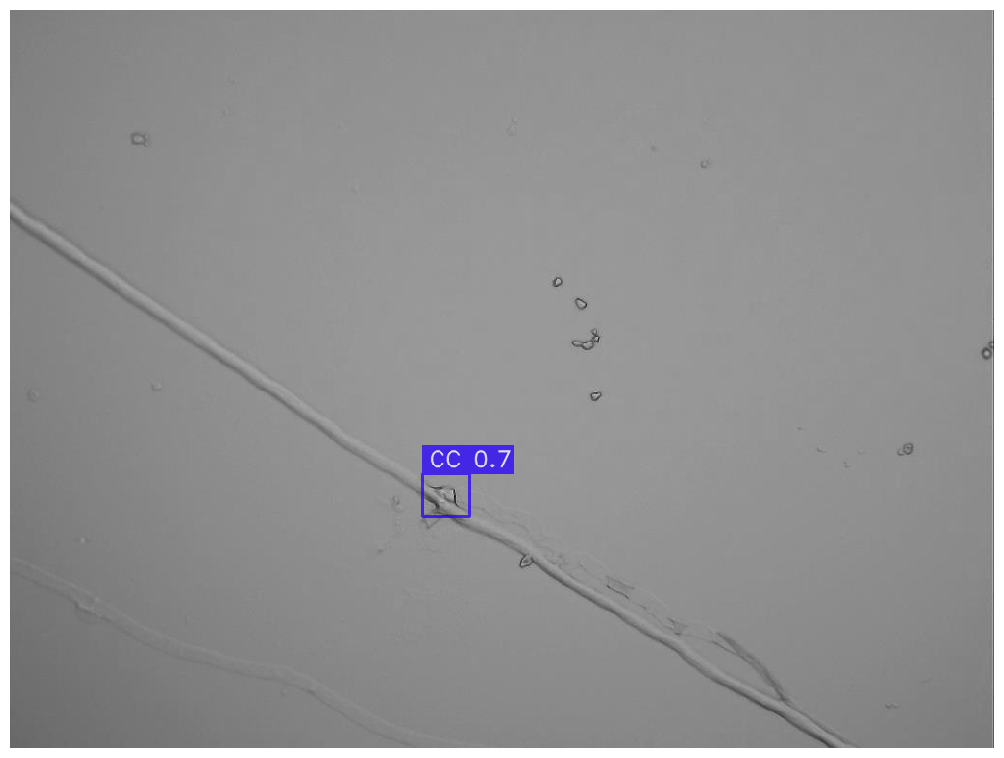

In [31]:
img_url = '/content/CCHA_detector-5/test/images/clampconnection-26-_jpg.rf.8d55af00eab3036df36d76b25688a025.jpg'
best_model.predict(img_url).show()

In [32]:
!pip install onemetric

NotImplementedError: ignored

In [33]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)

ModuleNotFoundError: ignored

# Post training quantization (PTQ) and quantization aware training (QAT)

SuperGradients offers PTQ and QAT out of the box. That's beyond the scope of this introductory tutorial. It is, in my opinion, a truly awesome feature.

Not many training libaries offer this out of the box.  You can learn more about PTQ and QAT [here](https://github.com/Deci-AI/super-gradients/blob/c339e2619616878172c060e6491c8c2129ed3fd4/documentation/source/ptq_qat.md).

An example specific to YOLONAS can be found [here](https://github.com/Deci-AI/super-gradients/blob/feature/SG-736_deci_yolo_rf100/documentation/source/qat_ptq_yolo_nas.md).

# 💫 I think you're ready to venture out on your own now!

I've created a templated notebook for you [here](https://colab.research.google.com/drive/10N6NmSMCiRnFlKV9kaIS_z3pk0OI1xKC?usp=sharing).

If you run into any issues, you know how to get a hold of me (contact info is at the top of the notebook).

Cheers and I can't wait to see what you come up with!